In [1]:
import warnings
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
import mne
import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery
from mne.decoding import CSP
from mne import Epochs, pick_types, events_from_annotations
from pykan.kan import KAN
from sklearn.metrics import f1_score, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import torch
import numpy as np
from torch.nn import Sequential, Linear, ReLU, CrossEntropyLoss, Module
from pykan.kan import LBFGS 
from torch.utils.data import DataLoader, TensorDataset
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')# if torch.cuda.is_available() else 'cpu')

import torch.optim as optim
from tqdm import tqdm
import time
import json


epochs=20 # It refers to the number of times the algorithm sees the entire data set, it can be a bit confusing because it is not the same as the epochs in the EEG signal processing
batch = 16
lr = 0.1
loss_fn = CrossEntropyLoss()
steps=50
kf = KFold(n_splits=10, shuffle=True, random_state=42)  
subjects= [1]
le = LabelEncoder()
hidden_layers= 10

moabb.set_log_level("info")
warnings.filterwarnings("ignore")
csp = CSP(n_components=4, reg='oas') # The number of component should be a paremeter to optimize 


In [2]:
def data_EEG(subjects, train=True, multiclass=False, tmin=2.5, tmax=6.0): # I will suggest to use the epoch definition 2.5 to 6.0, check slides to see the reason
        if train:
                session_name = "0train"

        else:
                session_name="1test"

        
        dataset = BNCI2014_001()
        if multiclass:
                event_id = dict(left=1, right=2, feet=3, tongue=4)
        else:
                event_id = dict(left=1, right=2)#, feet=3, tongue=4)

        # tmin, tmax = -1., 6. # This definition is too broad, it includes too much time before the event, I will suggest to use 2.5 to 6.0 that I have added as parameters above in the function definition
        runs = range(5)

        epochs_data=[]
        for subject in subjects:
                sessions = dataset.get_data(subjects=[subject])
                for run in runs:
                        raw = sessions[subject][session_name][str(run)]
                        events = mne.find_events(raw, stim_channel="stim")        
                        picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')
                        raw.filter(7., 35., method='iir', picks=picks)
                        
                        epochs = Epochs(raw,
                                events,
                                event_id,
                                tmin,
                                tmax,
                                proj=True,
                                picks=picks,
                                baseline=None,
                                preload=True,
                                verbose=False)
                        epochs_data.append(epochs)
        return epochs_data

def export_json(data, filename):
    for key, value in data.items():
        if isinstance(value, np.ndarray):
            data[key] = value.tolist()
        elif isinstance(value, list) and all(isinstance(x, list) for x in value):  # Check if ALL items are lists
            data[key] = [[float(item) for item in sublist] for sublist in value]  # Convert inner elements to float
        elif isinstance(value, list): 
            data[key] = [float(item) for item in value]  # Convert the numbers to float in the list 


    with open(filename, "w") as outfile:
        json.dump(data, outfile, indent=4)


In [3]:
def creating_models(input_shape, output_shape):
    kan_model = KAN(width=[input_shape, output_shape], grid=3, k=3, 
    seed=0, device=device)         

    for param in kan_model.parameters():
        param.data = param.data.double()
        
    return kan_model

class MLP(Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = Sequential(
            Linear(input_dim, hidden_dim),
            ReLU(),  # Activation function (you can experiment with others)
            Linear(hidden_dim, output_dim)  # Output layer
        )

    def forward(self, x):
        return self.layers(x)


    def train(self, dataset, opt="LBFGS", steps=100, log=1, lamb=0., lamb_l1=1., lamb_entropy=2., lamb_coef=0., lamb_coefdiff=0., update_grid=True, grid_update_num=10, loss_fn=None, lr=1., stop_grid_update_step=50, batch=-1,
              small_mag_threshold=1e-16, small_reg_factor=1., metrics=None, sglr_avoid=False, save_fig=False, in_vars=None, out_vars=None, beta=3, save_fig_freq=1, img_folder='./video', device='cpu'):
        '''
        training

        Args:
        -----
            dataset : dic
                contains dataset['train_input'], dataset['train_label'], dataset['test_input'], dataset['test_label']
            opt : str
                "LBFGS" or "Adam"
            steps : int
                training steps
            log : int
                logging frequency
            lamb : float
                overall penalty strength
            lamb_l1 : float
                l1 penalty strength
            lamb_entropy : float
                entropy penalty strength
            lamb_coef : float
                coefficient magnitude penalty strength
            lamb_coefdiff : float
                difference of nearby coefficits (smoothness) penalty strength
            update_grid : bool
                If True, update grid regularly before stop_grid_update_step
            grid_update_num : int
                the number of grid updates before stop_grid_update_step
            stop_grid_update_step : int
                no grid updates after this training step
            batch : int
                batch size, if -1 then full.
            small_mag_threshold : float
                threshold to determine large or small numbers (may want to apply larger penalty to smaller numbers)
            small_reg_factor : float
                penalty strength applied to small factors relative to large factos
            device : str
                device   
            save_fig_freq : int
                save figure every (save_fig_freq) step

        Returns:
        --------
            results : dic
                results['train_loss'], 1D array of training losses (RMSE)
                results['test_loss'], 1D array of test losses (RMSE)
                results['reg'], 1D array of regularization

        Example
        -------
        >>> # for interactive examples, please see demos
        >>> from utils import create_dataset
        >>> model = KAN(width=[2,5,1], grid=5, k=3, noise_scale=0.1, seed=0)
        >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
        >>> dataset = create_dataset(f, n_var=2)
        >>> model.train(dataset, opt='LBFGS', steps=50, lamb=0.01);
        >>> model.plot()
        '''


        pbar = tqdm(range(steps), desc='description', ncols=100)
  
        if loss_fn == None:
            loss_fn = loss_fn_eval = lambda x, y: torch.mean((x - y) ** 2)
        else:
            loss_fn = loss_fn_eval = loss_fn

        acc = acc_eval = lambda x,y: torch.mean((torch.argmax(x, dim=1) == y).float())

        grid_update_freq = int(stop_grid_update_step / grid_update_num)

        if opt == "Adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        elif opt == "LBFGS":
            optimizer = LBFGS(self.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

        results = {}
        results['train_loss'] = []
        results['test_loss'] = []
        results['train_acc'] = []
        results['test_acc'] = []
        if metrics != None:
            for i in range(len(metrics)):
                results[metrics[i].__name__] = []

        if batch == -1 or batch > dataset['train_input'].shape[0]:
            batch_size = dataset['train_input'].shape[0]
            batch_size_test = dataset['test_input'].shape[0]
        else:
            batch_size = batch
            batch_size_test = batch

        global train_loss, train_acc

        def closure():
            global train_loss, train_acc
            optimizer.zero_grad()
            pred = self.forward(dataset['train_input'][train_id].to(device))
            if sglr_avoid == True:
                id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
            else:
                train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
            train_acc = acc(pred, dataset['train_label'][train_id].to(device))

            objective = train_loss + lamb
            objective.backward()
            return objective

        if save_fig:
            if not os.path.exists(img_folder):
                os.makedirs(img_folder)
        
        for _ in pbar:

            train_id = np.random.choice(dataset['train_input'].shape[0], batch_size, replace=False)
            test_id = np.random.choice(dataset['test_input'].shape[0], batch_size_test, replace=False)

            #if _ % grid_update_freq == 0 and _ < stop_grid_update_step and update_grid:
            #    self.update_grid_from_samples(dataset['train_input'][train_id].to(device))

            if opt == "LBFGS":
                optimizer.step(closure)

            if opt == "Adam":
                pred = self.forward(dataset['train_input'][train_id].to(device))
                if sglr_avoid == True:
                    id_ = torch.where(torch.isnan(torch.sum(pred, dim=1)) == False)[0]
                    train_loss = loss_fn(pred[id_], dataset['train_label'][train_id][id_].to(device))
                else:
                    train_loss = loss_fn(pred, dataset['train_label'][train_id].to(device))
                loss = train_loss + lamb
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            test_loss = loss_fn_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))
            test_acc = acc_eval(self.forward(dataset['test_input'][test_id].to(device)), dataset['test_label'][test_id].to(device))

            if _ % log == 0:
                pbar.set_description("train acc: %.3f | test acc: %.3f " % ((train_acc).cpu().detach().numpy(), (test_acc).cpu().detach().numpy()))

            if metrics != None:
                for i in range(len(metrics)):
                    results[metrics[i].__name__].append(metrics[i]().item())

            results['train_loss'].append(torch.sqrt(train_loss).cpu().detach().numpy())
            results['test_loss'].append(torch.sqrt(test_loss).cpu().detach().numpy())
            results['train_acc'].append(train_acc.cpu().detach().numpy())
            results['test_acc'].append(test_acc.cpu().detach().numpy())

            if save_fig and _ % save_fig_freq == 0:
                self.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title="Step {}".format(_), beta=beta)
                plt.savefig(img_folder + '/' + str(_) + '.jpg', bbox_inches='tight', dpi=200)
                plt.close()

        return results


<h1> TWO CLASS - CSP+LDA </h1>

The best number of components is: 8
The accuracy is: 0.9083333333333333
The F1 scoreis: 0.9081739130434783
The Cohen's Kappa score is: 0.8166666666666667
The confusion matrix is: Predicted   0   1
Actual           
0          52   8
1           3  57


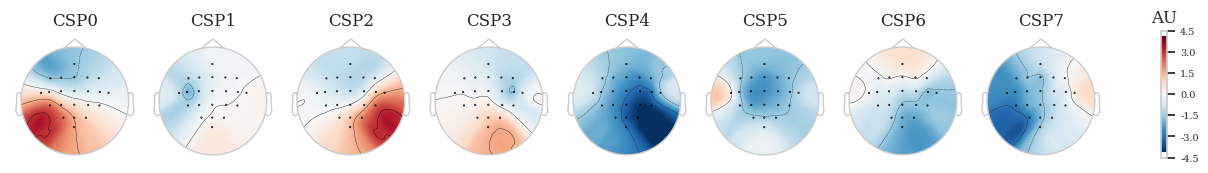

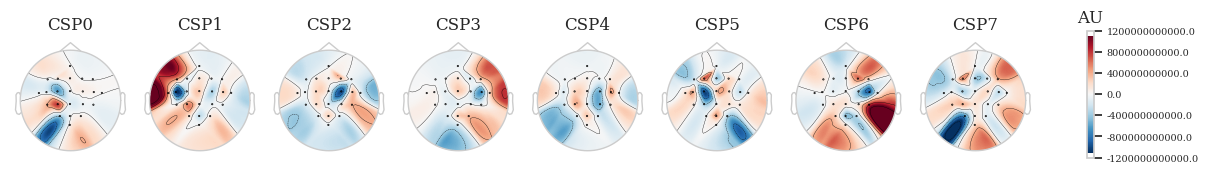

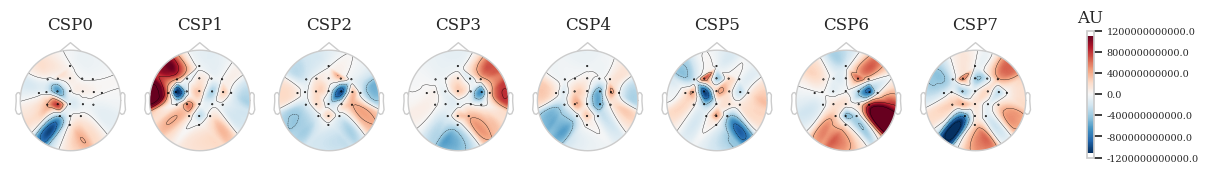

In [23]:
# Read the two class training data
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects))
y = epochs_EEG.events[:, -1]
y = le.fit_transform(y)

#sLDA
shrinkage_param = 0.1
lda = LDA(solver='lsqr', shrinkage=shrinkage_param)

# Perform cross-validation to find the best number of components
find_best_components = True
if find_best_components:
    n_components_range = range(4, 12)
    scores = []
    cv = StratifiedKFold(n_splits=5)
    X = epochs_EEG.get_data()
    
    for n_components in n_components_range:
        # Create CSP instance with the current number of components
        csp = CSP(n_components=n_components, reg='oas')
        # Create a pipeline with CSP and a classifier
        clf = make_pipeline(csp, lda)
        # Compute cross-validation score
        cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        scores.append(np.mean(cv_scores))

    # Find the best number of components
    best_n_components = n_components_range[np.argmax(scores)]
    print(f'The best number of components is: {best_n_components}')
else:
    best_n_components = 8

# Create a CSP instance with the best number of components
csp = CSP(n_components=best_n_components, reg='oas')
# Fit CSP on the training data
X = csp.fit_transform(epochs_EEG.get_data(), y) 
# fit classifier
lda.fit(X, y)


# Read the two class testing data
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects,train=False))
y_test = epochs_EEG.events[:, -1]
y_test = le.fit_transform(y_test)
X_test = csp.transform(epochs_EEG.get_data())

# Predict the labels of the test data
y_pred = lda.predict(X_test)
# Compute the accuracy
accuracy = lda.score(X_test, y_test)
print(f'The accuracy is: {accuracy}')
# Compute the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'The F1 scoreis: {f1}')
# Compute the Cohen's Kappa score   
kappa = cohen_kappa_score(y_test, y_pred)
print(f'The Cohen\'s Kappa score is: {kappa}')
# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix}')

#Plot csp patterns
csp.plot_patterns(epochs_EEG.info)
# Plot csp filters
csp.plot_filters(epochs_EEG.info)



<h1> MULTICLASS - CSP+LDA </h1>

The best number of components is: 14
The accuracy is: 0.7875
The F1 scoreis: 0.7886965358119853
The Cohen's Kappa score is: 0.7166666666666667
The confusion matrix is: Predicted   0   1   2   3
Actual                   
0          53   2   0   5
1          11  48   1   0
2           2   0  40  18
3           0   0  12  48


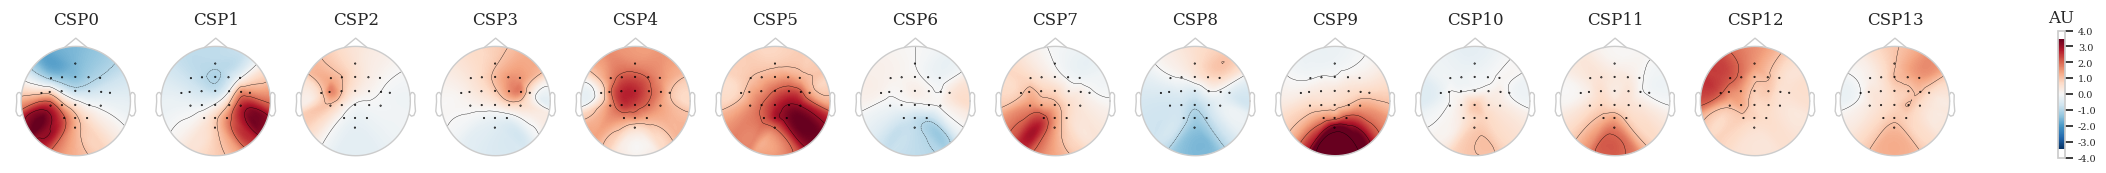

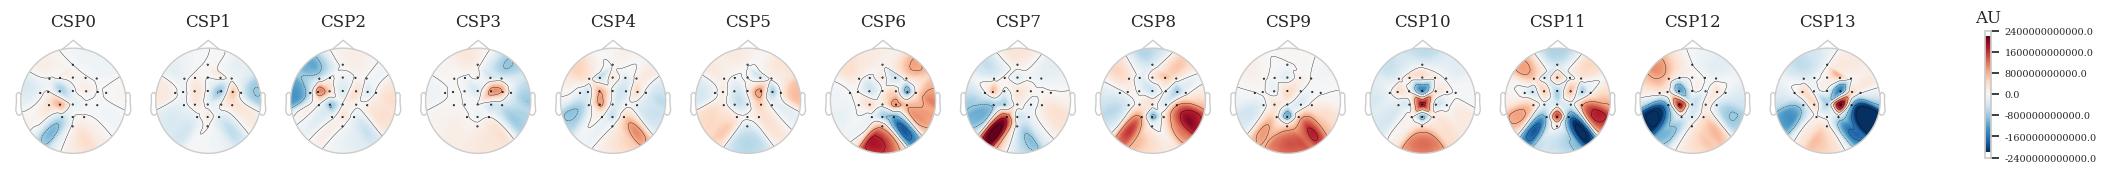

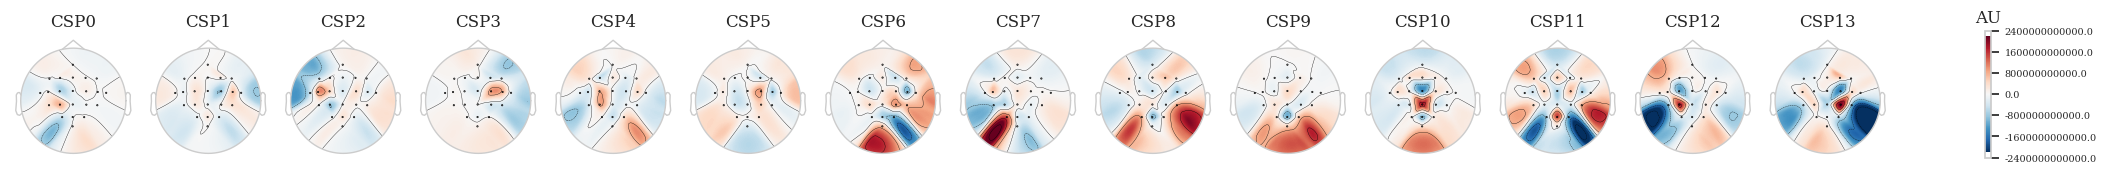

In [24]:
# Read the four class training data
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, multiclass=True))
y = epochs_EEG.events[:, -1]
y = le.fit_transform(y)

#sLDA
shrinkage_param = 0.1
lda = LDA(solver='lsqr', shrinkage=shrinkage_param)

# Perform cross-validation to find the best number of components
find_best_components = True
if find_best_components:
    n_components_range = range(2, 20)
    scores = []
    cv = StratifiedKFold(n_splits=5)
    X = epochs_EEG.get_data()
    
    for n_components in n_components_range:
        # Create CSP instance with the current number of components
        csp = CSP(n_components=n_components, reg='oas')
        # Create a pipeline with CSP and a classifier
        clf = make_pipeline(csp, lda)
        # Compute cross-validation score
        cv_scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        scores.append(np.mean(cv_scores))

    # Find the best number of components
    best_n_components = n_components_range[np.argmax(scores)]
    print(f'The best number of components is: {best_n_components}')
else:
    best_n_components = 14

# Create a CSP instance with the best number of components
csp = CSP(n_components=best_n_components, reg='oas')
# Fit CSP on the training data
X = csp.fit_transform(epochs_EEG.get_data(), y) 
# fit classifier
lda.fit(X, y)


# Read the four class testing data
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects,train=False,multiclass=True))
y_test = epochs_EEG.events[:, -1]
y_test = le.fit_transform(y_test)
X_test = csp.transform(epochs_EEG.get_data())

# Predict the labels of the test data
y_pred = lda.predict(X_test)
# Compute the accuracy
accuracy = lda.score(X_test, y_test)
print(f'The accuracy is: {accuracy}')
# Compute the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'The F1 scoreis: {f1}')
# Compute the Cohen's Kappa score   
kappa = cohen_kappa_score(y_test, y_pred)
print(f'The Cohen\'s Kappa score is: {kappa}')
# Compute the confusion matrix
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix}')

#Plot csp patterns
csp.plot_patterns(epochs_EEG.info)
# Plot csp filters
csp.plot_filters(epochs_EEG.info)
  

<h1> TWO CLASS - RAW </h1>

In [5]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects))
df = epochs_EEG.to_data_frame().drop(columns=['time','epoch'])
X = df.drop(columns=['condition']).values
y = df.condition.values
y = le.fit_transform(y)

X = torch.from_numpy(X).double()
y  = torch.from_numpy(y).long()


input_layer = X.shape[1]
output_layer = len(np.unique(y))


kan_model  = creating_models(input_layer, output_layer)
kan_optimizer = LBFGS(kan_model.parameters(), lr=lr) 

mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

for param in mlp_model.parameters():
    param.data = param.data.double()
mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32) #(mlp_model.parameters(), lr=lr)


metrics_KAN = {}  
metrics_KAN['train'] = []
metrics_KAN['test'] = []

metrics_MLP = {}  
metrics_MLP['train'] = []
metrics_MLP['test'] = []

total_train_time_KAN = 0
total_train_time_MLP = 0

for fold, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dataset={}
    dataset['train_input']= X_train
    dataset['train_label']= y_train
    dataset['test_input']= X_test
    dataset['test_label']= y_test

    fold_metrics_KAN_train = []
    fold_metrics_KAN_test =[]
    fold_metrics_MLP_train = []
    fold_metrics_MLP_test =[]

    for epoch in range(epochs):
        print('###### EPOCH ', epoch, " ############")

        epoch_start_time_KAN = time.time()

        results_kan = kan_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=batch, lr=lr)
        
        epoch_end_time_KAN = time.time()
        epoch_train_KAN = epoch_end_time_KAN - epoch_start_time_KAN
        total_train_time_KAN += epoch_train_KAN
        
        epoch_start_time_MLP = time.time()

        fold_metrics_KAN_train.append(np.mean(results_kan['train_acc']))
        fold_metrics_KAN_test.append(np.mean(results_kan['test_acc'])) 

        results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=batch, lr=lr)

        epoch_end_time_MLP = time.time()
        epoch_train_MLP = epoch_end_time_MLP - epoch_start_time_MLP
        total_train_time_MLP += epoch_train_MLP
        
        fold_metrics_MLP_train.append(np.mean(results_mlp['train_acc']))
        fold_metrics_MLP_test.append(np.mean(results_mlp['test_acc'])) 

    metrics_KAN['train'].append(fold_metrics_KAN_train)
    metrics_KAN['test'].append(fold_metrics_KAN_test)
    
    metrics_MLP['train'].append(fold_metrics_MLP_train)
    metrics_MLP['test'].append(fold_metrics_MLP_test)

    
print(f"Training time KAN: {total_train_time_KAN:.2f} seconds")
print(f"Training time MLP: {total_train_time_MLP:.2f} seconds")
        

###### EPOCH  0  ############


train acc: 1.000 | test acc: 0.312 | reg: 14.121 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.875 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.77it/s]


###### EPOCH  1  ############


train acc: 0.812 | test acc: 0.562 | reg: 22.644 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.31it/s]


###### EPOCH  2  ############


train acc: 0.938 | test acc: 0.312 | reg: 15.380 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.09it/s]


###### EPOCH  3  ############


train acc: 0.875 | test acc: 0.688 | reg: 14.540 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.05it/s]


###### EPOCH  4  ############


train acc: 1.000 | test acc: 0.625 | reg: 16.577 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.64it/s]


###### EPOCH  5  ############


train acc: 1.000 | test acc: 0.375 | reg: 15.390 : 100%|████████████| 50/50 [00:09<00:00,  5.36it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.68it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.562 | reg: 15.958 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.812 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.52it/s]


###### EPOCH  7  ############


train acc: 1.000 | test acc: 0.375 | reg: 16.604 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.750 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.51it/s]


###### EPOCH  8  ############


train acc: 0.938 | test acc: 0.500 | reg: 17.303 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.688 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.00it/s]


###### EPOCH  9  ############


train acc: 0.750 | test acc: 0.375 | reg: 16.804 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.625 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.98it/s]


###### EPOCH  10  ############


train acc: 0.812 | test acc: 0.375 | reg: 15.723 : 100%|████████████| 50/50 [00:09<00:00,  5.27it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.57it/s]


###### EPOCH  11  ############


train acc: 0.875 | test acc: 0.500 | reg: 13.470 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.625 | test acc: 0.812 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.28it/s]


###### EPOCH  12  ############


train acc: 1.000 | test acc: 0.500 | reg: 14.081 : 100%|████████████| 50/50 [00:09<00:00,  5.29it/s]
train acc: 0.562 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.72it/s]


###### EPOCH  13  ############


train acc: 0.812 | test acc: 0.438 | reg: 13.711 : 100%|████████████| 50/50 [00:09<00:00,  5.27it/s]
train acc: 0.875 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.33it/s]


###### EPOCH  14  ############


train acc: 0.625 | test acc: 0.438 | reg: 20.063 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.33it/s]


###### EPOCH  15  ############


train acc: 0.750 | test acc: 0.312 | reg: 13.079 : 100%|████████████| 50/50 [00:09<00:00,  5.25it/s]
train acc: 0.812 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.69it/s]


###### EPOCH  16  ############


train acc: 0.938 | test acc: 0.750 | reg: 18.106 : 100%|████████████| 50/50 [00:09<00:00,  5.36it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.93it/s]


###### EPOCH  17  ############


train acc: 1.000 | test acc: 0.562 | reg: 21.107 : 100%|████████████| 50/50 [00:09<00:00,  5.25it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.63it/s]


###### EPOCH  18  ############


train acc: 0.750 | test acc: 0.438 | reg: 16.656 : 100%|████████████| 50/50 [00:09<00:00,  5.28it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.28it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.625 | reg: 18.548 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.96it/s]


###### EPOCH  0  ############


train acc: 0.938 | test acc: 0.438 | reg: 19.990 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.34it/s]


###### EPOCH  1  ############


train acc: 1.000 | test acc: 0.250 | reg: 14.410 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.938 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.36it/s]


###### EPOCH  2  ############


train acc: 0.938 | test acc: 0.688 | reg: 12.352 : 100%|████████████| 50/50 [00:09<00:00,  5.29it/s]
train acc: 0.375 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.24it/s]


###### EPOCH  3  ############


train acc: 1.000 | test acc: 0.500 | reg: 13.646 : 100%|████████████| 50/50 [00:09<00:00,  5.26it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.96it/s]


###### EPOCH  4  ############


train acc: 0.875 | test acc: 0.562 | reg: 13.019 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.875 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.33it/s]


###### EPOCH  5  ############


train acc: 0.938 | test acc: 0.625 | reg: 13.661 : 100%|████████████| 50/50 [00:09<00:00,  5.27it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.89it/s]


###### EPOCH  6  ############


train acc: 1.000 | test acc: 0.688 | reg: 13.909 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.08it/s]


###### EPOCH  7  ############


train acc: 0.875 | test acc: 0.438 | reg: 14.331 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.10it/s]


###### EPOCH  8  ############


train acc: 1.000 | test acc: 0.562 | reg: 19.050 : 100%|████████████| 50/50 [00:09<00:00,  5.29it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.96it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.625 | reg: 16.705 : 100%|████████████| 50/50 [00:12<00:00,  4.03it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.50it/s]


###### EPOCH  10  ############


train acc: 0.688 | test acc: 0.312 | reg: 13.952 : 100%|████████████| 50/50 [00:14<00:00,  3.54it/s]
train acc: 0.562 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.15it/s]


###### EPOCH  11  ############


train acc: 1.000 | test acc: 0.750 | reg: 15.914 : 100%|████████████| 50/50 [00:13<00:00,  3.79it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.40it/s]


###### EPOCH  12  ############


train acc: 0.500 | test acc: 0.500 | reg: 14.094 : 100%|████████████| 50/50 [00:13<00:00,  3.64it/s]
train acc: 0.625 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.15it/s]


###### EPOCH  13  ############


train acc: 0.500 | test acc: 0.500 | reg: 19.290 : 100%|████████████| 50/50 [00:16<00:00,  3.01it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.51it/s]


###### EPOCH  14  ############


train acc: 0.750 | test acc: 0.438 | reg: 13.307 : 100%|████████████| 50/50 [00:14<00:00,  3.54it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.60it/s]


###### EPOCH  15  ############


train acc: 0.938 | test acc: 0.500 | reg: 14.232 : 100%|████████████| 50/50 [00:14<00:00,  3.56it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.94it/s]


###### EPOCH  16  ############


train acc: 0.938 | test acc: 0.188 | reg: 14.168 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.44it/s]


###### EPOCH  17  ############


train acc: 0.812 | test acc: 0.625 | reg: 14.867 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.61it/s]


###### EPOCH  18  ############


train acc: 0.750 | test acc: 0.562 | reg: 16.230 : 100%|████████████| 50/50 [00:09<00:00,  5.36it/s]
train acc: 0.625 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.95it/s]


###### EPOCH  19  ############


train acc: 0.812 | test acc: 0.562 | reg: 13.157 : 100%|████████████| 50/50 [00:09<00:00,  5.13it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.64it/s]


###### EPOCH  0  ############


train acc: 1.000 | test acc: 0.500 | reg: 15.093 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.53it/s]


###### EPOCH  1  ############


train acc: 0.938 | test acc: 0.500 | reg: 13.867 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.47it/s]


###### EPOCH  2  ############


train acc: 1.000 | test acc: 0.625 | reg: 18.673 : 100%|████████████| 50/50 [00:09<00:00,  5.43it/s]
train acc: 0.562 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.87it/s]


###### EPOCH  3  ############


train acc: 1.000 | test acc: 0.750 | reg: 13.796 : 100%|████████████| 50/50 [00:09<00:00,  5.42it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.49it/s]


###### EPOCH  4  ############


train acc: 0.875 | test acc: 0.562 | reg: 18.152 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.562 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.36it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.688 | reg: 25.888 : 100%|████████████| 50/50 [00:09<00:00,  5.42it/s]
train acc: 0.500 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.47it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.188 | reg: 14.985 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.750 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.62it/s]


###### EPOCH  7  ############


train acc: 0.812 | test acc: 0.375 | reg: 15.818 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.89it/s]


###### EPOCH  8  ############


train acc: 1.000 | test acc: 0.500 | reg: 15.297 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 0.875 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.90it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.500 | reg: 16.306 : 100%|████████████| 50/50 [00:09<00:00,  5.50it/s]
train acc: 0.812 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.26it/s]


###### EPOCH  10  ############


train acc: 1.000 | test acc: 0.438 | reg: 17.252 : 100%|████████████| 50/50 [00:09<00:00,  5.51it/s]
train acc: 0.938 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.25it/s]


###### EPOCH  11  ############


train acc: 1.000 | test acc: 0.500 | reg: 14.777 : 100%|████████████| 50/50 [00:09<00:00,  5.51it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.39it/s]


###### EPOCH  12  ############


train acc: 0.875 | test acc: 0.562 | reg: 18.759 : 100%|████████████| 50/50 [00:09<00:00,  5.25it/s]
train acc: 0.750 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.23it/s]


###### EPOCH  13  ############


train acc: 1.000 | test acc: 0.438 | reg: 15.824 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.88it/s]


###### EPOCH  14  ############


train acc: 0.938 | test acc: 0.625 | reg: 16.114 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.16it/s]


###### EPOCH  15  ############


train acc: 1.000 | test acc: 0.562 | reg: 14.602 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.812 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.23it/s]


###### EPOCH  16  ############


train acc: 1.000 | test acc: 0.625 | reg: 15.291 : 100%|████████████| 50/50 [00:09<00:00,  5.45it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.51it/s]


###### EPOCH  17  ############


train acc: 0.875 | test acc: 0.750 | reg: 13.303 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 0.875 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.25it/s]


###### EPOCH  18  ############


train acc: 0.938 | test acc: 0.688 | reg: 14.092 : 100%|████████████| 50/50 [00:09<00:00,  5.49it/s]
train acc: 0.750 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.72it/s]


###### EPOCH  19  ############


train acc: 0.812 | test acc: 0.562 | reg: 16.859 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.63it/s]


###### EPOCH  0  ############


train acc: 0.750 | test acc: 0.438 | reg: 16.446 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.98it/s]


###### EPOCH  1  ############


train acc: 0.938 | test acc: 0.562 | reg: 11.569 : 100%|████████████| 50/50 [00:09<00:00,  5.28it/s]
train acc: 0.625 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.61it/s]


###### EPOCH  2  ############


train acc: 0.688 | test acc: 0.500 | reg: 15.387 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.875 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.51it/s]


###### EPOCH  3  ############


train acc: 1.000 | test acc: 0.438 | reg: 19.687 : 100%|████████████| 50/50 [00:09<00:00,  5.38it/s]
train acc: 0.625 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.90it/s]


###### EPOCH  4  ############


train acc: 0.688 | test acc: 0.562 | reg: 18.370 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.29it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.562 | reg: 17.241 : 100%|████████████| 50/50 [00:09<00:00,  5.29it/s]
train acc: 0.938 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.93it/s]


###### EPOCH  6  ############


train acc: 0.688 | test acc: 0.562 | reg: 17.365 : 100%|████████████| 50/50 [00:10<00:00,  4.98it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.52it/s]


###### EPOCH  7  ############


train acc: 0.625 | test acc: 0.500 | reg: 16.291 : 100%|████████████| 50/50 [00:12<00:00,  3.85it/s]
train acc: 0.812 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.22it/s]


###### EPOCH  8  ############


train acc: 0.875 | test acc: 0.562 | reg: 15.396 : 100%|████████████| 50/50 [00:10<00:00,  4.94it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.08it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.625 | reg: 13.495 : 100%|████████████| 50/50 [00:09<00:00,  5.50it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.38it/s]


###### EPOCH  10  ############


train acc: 0.812 | test acc: 0.500 | reg: 13.998 : 100%|████████████| 50/50 [00:09<00:00,  5.47it/s]
train acc: 0.562 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.67it/s]


###### EPOCH  11  ############


train acc: 0.625 | test acc: 0.562 | reg: 12.172 : 100%|████████████| 50/50 [00:09<00:00,  5.53it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.85it/s]


###### EPOCH  12  ############


train acc: 0.812 | test acc: 0.438 | reg: 15.463 : 100%|████████████| 50/50 [00:08<00:00,  5.58it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.59it/s]


###### EPOCH  13  ############


train acc: 0.938 | test acc: 0.438 | reg: 11.914 : 100%|████████████| 50/50 [00:08<00:00,  5.63it/s]
train acc: 0.562 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.83it/s]


###### EPOCH  14  ############


train acc: 0.875 | test acc: 0.625 | reg: 15.524 : 100%|████████████| 50/50 [00:08<00:00,  5.59it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.29it/s]


###### EPOCH  15  ############


train acc: 0.625 | test acc: 0.750 | reg: 14.993 : 100%|████████████| 50/50 [00:09<00:00,  5.49it/s]
train acc: 0.438 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.06it/s]


###### EPOCH  16  ############


train acc: 0.875 | test acc: 0.625 | reg: 14.127 : 100%|████████████| 50/50 [00:08<00:00,  5.56it/s]
train acc: 0.625 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.94it/s]


###### EPOCH  17  ############


train acc: 0.938 | test acc: 0.688 | reg: 12.579 : 100%|████████████| 50/50 [00:09<00:00,  5.48it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.22it/s]


###### EPOCH  18  ############


train acc: 0.812 | test acc: 0.375 | reg: 12.503 : 100%|████████████| 50/50 [00:09<00:00,  5.42it/s]
train acc: 0.625 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.04it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.500 | reg: 13.212 : 100%|████████████| 50/50 [00:09<00:00,  5.43it/s]
train acc: 0.875 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.65it/s]


###### EPOCH  0  ############


train acc: 1.000 | test acc: 0.562 | reg: 14.185 : 100%|████████████| 50/50 [00:09<00:00,  5.48it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.63it/s]


###### EPOCH  1  ############


train acc: 0.688 | test acc: 0.625 | reg: 13.801 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.22it/s]


###### EPOCH  2  ############


train acc: 0.875 | test acc: 0.625 | reg: 13.360 : 100%|████████████| 50/50 [00:09<00:00,  5.38it/s]
train acc: 0.812 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.21it/s]


###### EPOCH  3  ############


train acc: 0.875 | test acc: 0.375 | reg: 13.441 : 100%|████████████| 50/50 [00:09<00:00,  5.38it/s]
train acc: 0.625 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.38it/s]


###### EPOCH  4  ############


train acc: 0.750 | test acc: 0.562 | reg: 12.714 : 100%|████████████| 50/50 [00:09<00:00,  5.55it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.00it/s]


###### EPOCH  5  ############


train acc: 0.938 | test acc: 0.688 | reg: 15.234 : 100%|████████████| 50/50 [00:09<00:00,  5.53it/s]
train acc: 0.812 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.11it/s]


###### EPOCH  6  ############


train acc: 0.812 | test acc: 0.438 | reg: 12.997 : 100%|████████████| 50/50 [00:09<00:00,  5.49it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.83it/s]


###### EPOCH  7  ############


train acc: 1.000 | test acc: 0.250 | reg: 10.766 : 100%|████████████| 50/50 [00:09<00:00,  5.41it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.20it/s]


###### EPOCH  8  ############


train acc: 0.938 | test acc: 0.688 | reg: 12.210 : 100%|████████████| 50/50 [00:09<00:00,  5.45it/s]
train acc: 0.812 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.10it/s]


###### EPOCH  9  ############


train acc: 0.688 | test acc: 0.312 | reg: 13.387 : 100%|████████████| 50/50 [00:09<00:00,  5.44it/s]
train acc: 0.750 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.31it/s]


###### EPOCH  10  ############


train acc: 0.938 | test acc: 0.562 | reg: 13.025 : 100%|████████████| 50/50 [00:09<00:00,  5.40it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.52it/s]


###### EPOCH  11  ############


train acc: 0.688 | test acc: 0.688 | reg: 13.135 : 100%|████████████| 50/50 [00:09<00:00,  5.44it/s]
train acc: 0.625 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.52it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.500 | reg: 11.766 : 100%|████████████| 50/50 [00:10<00:00,  4.75it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.92it/s]


###### EPOCH  13  ############


train acc: 0.688 | test acc: 0.625 | reg: 12.319 : 100%|████████████| 50/50 [00:10<00:00,  4.68it/s]
train acc: 0.312 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.84it/s]


###### EPOCH  14  ############


train acc: 0.875 | test acc: 0.562 | reg: 12.999 : 100%|████████████| 50/50 [00:09<00:00,  5.42it/s]
train acc: 0.562 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.57it/s]


###### EPOCH  15  ############


train acc: 0.750 | test acc: 0.688 | reg: 12.911 : 100%|████████████| 50/50 [00:09<00:00,  5.50it/s]
train acc: 0.500 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.29it/s]


###### EPOCH  16  ############


train acc: 0.875 | test acc: 0.500 | reg: 12.213 : 100%|████████████| 50/50 [00:09<00:00,  5.41it/s]
train acc: 0.750 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.02it/s]


###### EPOCH  17  ############


train acc: 0.875 | test acc: 0.625 | reg: 11.849 : 100%|████████████| 50/50 [00:11<00:00,  4.22it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.14it/s]


###### EPOCH  18  ############


train acc: 0.938 | test acc: 0.438 | reg: 13.022 : 100%|████████████| 50/50 [00:13<00:00,  3.78it/s]
train acc: 0.500 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.12it/s]


###### EPOCH  19  ############


train acc: 0.812 | test acc: 0.688 | reg: 13.293 : 100%|████████████| 50/50 [00:12<00:00,  3.90it/s]
train acc: 0.812 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.55it/s]


###### EPOCH  0  ############


train acc: 1.000 | test acc: 0.625 | reg: 13.042 : 100%|████████████| 50/50 [00:13<00:00,  3.70it/s]
train acc: 0.625 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.68it/s]


###### EPOCH  1  ############


train acc: 0.812 | test acc: 0.500 | reg: 13.453 : 100%|████████████| 50/50 [00:12<00:00,  3.92it/s]
train acc: 0.562 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.76it/s]


###### EPOCH  2  ############


train acc: 0.875 | test acc: 0.438 | reg: 13.010 : 100%|████████████| 50/50 [00:12<00:00,  3.99it/s]
train acc: 0.562 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.14it/s]


###### EPOCH  3  ############


train acc: 0.875 | test acc: 0.688 | reg: 12.036 : 100%|████████████| 50/50 [00:12<00:00,  3.91it/s]
train acc: 0.812 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.11it/s]


###### EPOCH  4  ############


train acc: 1.000 | test acc: 0.312 | reg: 12.599 : 100%|████████████| 50/50 [00:12<00:00,  4.08it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.45it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.562 | reg: 13.236 : 100%|████████████| 50/50 [00:09<00:00,  5.50it/s]
train acc: 0.688 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.08it/s]


###### EPOCH  6  ############


train acc: 0.938 | test acc: 0.812 | reg: 12.972 : 100%|████████████| 50/50 [00:08<00:00,  5.62it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.97it/s]


###### EPOCH  7  ############


train acc: 1.000 | test acc: 0.562 | reg: 14.933 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.875 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.50it/s]


###### EPOCH  8  ############


train acc: 0.875 | test acc: 0.625 | reg: 12.928 : 100%|████████████| 50/50 [00:08<00:00,  5.62it/s]
train acc: 0.500 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.42it/s]


###### EPOCH  9  ############


train acc: 0.875 | test acc: 0.250 | reg: 13.542 : 100%|████████████| 50/50 [00:09<00:00,  5.41it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.02it/s]


###### EPOCH  10  ############


train acc: 0.750 | test acc: 0.312 | reg: 13.740 : 100%|████████████| 50/50 [00:09<00:00,  5.47it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.80it/s]


###### EPOCH  11  ############


train acc: 0.688 | test acc: 0.500 | reg: 13.703 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.438 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.21it/s]


###### EPOCH  12  ############


train acc: 1.000 | test acc: 0.438 | reg: 13.161 : 100%|████████████| 50/50 [00:09<00:00,  5.52it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.92it/s]


###### EPOCH  13  ############


train acc: 0.812 | test acc: 0.562 | reg: 13.596 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.45it/s]


###### EPOCH  14  ############


train acc: 0.688 | test acc: 0.562 | reg: 13.000 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 1.000 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.54it/s]


###### EPOCH  15  ############


train acc: 0.688 | test acc: 0.625 | reg: 13.178 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.49it/s]


###### EPOCH  16  ############


train acc: 0.938 | test acc: 0.562 | reg: 14.360 : 100%|████████████| 50/50 [00:09<00:00,  5.51it/s]
train acc: 0.875 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.86it/s]


###### EPOCH  17  ############


train acc: 1.000 | test acc: 0.375 | reg: 15.453 : 100%|████████████| 50/50 [00:08<00:00,  5.57it/s]
train acc: 0.562 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.74it/s]


###### EPOCH  18  ############


train acc: 1.000 | test acc: 0.375 | reg: 14.787 : 100%|████████████| 50/50 [00:09<00:00,  5.53it/s]
train acc: 0.562 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.38it/s]


###### EPOCH  19  ############


train acc: 1.000 | test acc: 0.562 | reg: 13.454 : 100%|████████████| 50/50 [00:09<00:00,  5.47it/s]
train acc: 0.750 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.78it/s]


###### EPOCH  0  ############


train acc: 0.938 | test acc: 0.438 | reg: 13.347 : 100%|████████████| 50/50 [00:09<00:00,  5.41it/s]
train acc: 0.875 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.03it/s]


###### EPOCH  1  ############


train acc: 0.875 | test acc: 0.625 | reg: 14.273 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.40it/s]


###### EPOCH  2  ############


train acc: 1.000 | test acc: 0.375 | reg: 17.538 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.38it/s]


###### EPOCH  3  ############


train acc: 0.625 | test acc: 0.500 | reg: 14.064 : 100%|████████████| 50/50 [00:09<00:00,  5.38it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.97it/s]


###### EPOCH  4  ############


train acc: 1.000 | test acc: 0.375 | reg: 19.312 : 100%|████████████| 50/50 [00:09<00:00,  5.41it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.92it/s]


###### EPOCH  5  ############


train acc: 0.750 | test acc: 0.562 | reg: 15.697 : 100%|████████████| 50/50 [00:09<00:00,  5.46it/s]
train acc: 0.688 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.16it/s]


###### EPOCH  6  ############


train acc: 1.000 | test acc: 0.500 | reg: 12.395 : 100%|████████████| 50/50 [00:09<00:00,  5.47it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.99it/s]


###### EPOCH  7  ############


train acc: 1.000 | test acc: 0.438 | reg: 13.498 : 100%|████████████| 50/50 [00:09<00:00,  5.47it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.58it/s]


###### EPOCH  8  ############


train acc: 0.938 | test acc: 0.188 | reg: 12.132 : 100%|████████████| 50/50 [00:08<00:00,  5.58it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.57it/s]


###### EPOCH  9  ############


train acc: 0.812 | test acc: 0.688 | reg: 12.649 : 100%|████████████| 50/50 [00:09<00:00,  5.56it/s]
train acc: 0.562 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.53it/s]


###### EPOCH  10  ############


train acc: 0.875 | test acc: 0.438 | reg: 11.054 : 100%|████████████| 50/50 [00:09<00:00,  5.52it/s]
train acc: 0.562 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.13it/s]


###### EPOCH  11  ############


train acc: 0.875 | test acc: 0.375 | reg: 12.024 : 100%|████████████| 50/50 [00:09<00:00,  5.49it/s]
train acc: 0.750 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 56.71it/s]


###### EPOCH  12  ############


train acc: 0.750 | test acc: 0.500 | reg: 13.476 : 100%|████████████| 50/50 [00:09<00:00,  5.45it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.96it/s]


###### EPOCH  13  ############


train acc: 1.000 | test acc: 0.625 | reg: 16.664 : 100%|████████████| 50/50 [00:13<00:00,  3.84it/s]
train acc: 0.688 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.10it/s]


###### EPOCH  14  ############


train acc: 0.875 | test acc: 0.500 | reg: 11.271 : 100%|████████████| 50/50 [00:12<00:00,  3.97it/s]
train acc: 0.688 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.98it/s]


###### EPOCH  15  ############


train acc: 0.875 | test acc: 0.562 | reg: 13.952 : 100%|████████████| 50/50 [00:13<00:00,  3.73it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.89it/s]


###### EPOCH  16  ############


train acc: 0.688 | test acc: 0.688 | reg: 15.255 : 100%|████████████| 50/50 [00:12<00:00,  3.92it/s]
train acc: 0.500 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.15it/s]


###### EPOCH  17  ############


train acc: 1.000 | test acc: 0.500 | reg: 16.151 : 100%|████████████| 50/50 [00:12<00:00,  3.89it/s]
train acc: 0.688 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.62it/s]


###### EPOCH  18  ############


train acc: 0.812 | test acc: 0.625 | reg: 14.589 : 100%|████████████| 50/50 [00:12<00:00,  3.90it/s]
train acc: 0.938 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.48it/s]


###### EPOCH  19  ############


train acc: 0.562 | test acc: 0.625 | reg: 13.938 : 100%|████████████| 50/50 [00:12<00:00,  4.06it/s]
train acc: 0.562 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.01it/s]


###### EPOCH  0  ############


train acc: 0.938 | test acc: 0.438 | reg: 18.037 : 100%|████████████| 50/50 [00:12<00:00,  3.96it/s]
train acc: 0.875 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.20it/s]


###### EPOCH  1  ############


train acc: 0.938 | test acc: 0.562 | reg: 13.440 : 100%|████████████| 50/50 [00:12<00:00,  3.98it/s]
train acc: 0.812 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.72it/s]


###### EPOCH  2  ############


train acc: 0.875 | test acc: 0.438 | reg: 20.216 : 100%|████████████| 50/50 [00:13<00:00,  3.74it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.98it/s]


###### EPOCH  3  ############


train acc: 0.688 | test acc: 0.625 | reg: 15.795 : 100%|████████████| 50/50 [00:12<00:00,  3.95it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.50it/s]


###### EPOCH  4  ############


train acc: 0.750 | test acc: 0.500 | reg: 17.060 : 100%|████████████| 50/50 [00:12<00:00,  3.92it/s]
train acc: 0.375 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.65it/s]


###### EPOCH  5  ############


train acc: 1.000 | test acc: 0.500 | reg: 15.578 : 100%|████████████| 50/50 [00:13<00:00,  3.82it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.25it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.438 | reg: 16.171 : 100%|████████████| 50/50 [00:13<00:00,  3.75it/s]
train acc: 0.688 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.24it/s]


###### EPOCH  7  ############


train acc: 0.875 | test acc: 0.562 | reg: 15.747 : 100%|████████████| 50/50 [00:13<00:00,  3.59it/s]
train acc: 0.625 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.98it/s]


###### EPOCH  8  ############


train acc: 0.938 | test acc: 0.562 | reg: 13.577 : 100%|████████████| 50/50 [00:13<00:00,  3.80it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.07it/s]


###### EPOCH  9  ############


train acc: 1.000 | test acc: 0.562 | reg: 17.962 : 100%|████████████| 50/50 [00:12<00:00,  3.89it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 42.38it/s]


###### EPOCH  10  ############


train acc: 0.875 | test acc: 0.500 | reg: 19.830 : 100%|████████████| 50/50 [00:13<00:00,  3.69it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.00it/s]


###### EPOCH  11  ############


train acc: 0.750 | test acc: 0.562 | reg: 16.552 : 100%|████████████| 50/50 [00:13<00:00,  3.73it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.37it/s]


###### EPOCH  12  ############


train acc: 0.812 | test acc: 0.375 | reg: 12.365 : 100%|████████████| 50/50 [00:12<00:00,  4.04it/s]
train acc: 0.625 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.04it/s]


###### EPOCH  13  ############


train acc: 0.812 | test acc: 0.250 | reg: 14.362 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.938 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.19it/s]


###### EPOCH  14  ############


train acc: 0.812 | test acc: 0.625 | reg: 17.373 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.27it/s]


###### EPOCH  15  ############


train acc: 0.750 | test acc: 0.438 | reg: 14.170 : 100%|████████████| 50/50 [00:09<00:00,  5.30it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.32it/s]


###### EPOCH  16  ############


train acc: 1.000 | test acc: 0.625 | reg: 17.097 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.38it/s]


###### EPOCH  17  ############


train acc: 0.938 | test acc: 0.500 | reg: 14.837 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.688 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.99it/s]


###### EPOCH  18  ############


train acc: 0.812 | test acc: 0.312 | reg: 15.787 : 100%|████████████| 50/50 [00:09<00:00,  5.26it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 55.19it/s]


###### EPOCH  19  ############


train acc: 1.000 | test acc: 0.562 | reg: 13.993 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.812 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.15it/s]


###### EPOCH  0  ############


train acc: 0.875 | test acc: 0.562 | reg: 13.880 : 100%|████████████| 50/50 [00:09<00:00,  5.26it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.18it/s]


###### EPOCH  1  ############


train acc: 0.625 | test acc: 0.375 | reg: 15.211 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.42it/s]


###### EPOCH  2  ############


train acc: 0.688 | test acc: 0.750 | reg: 13.718 : 100%|████████████| 50/50 [00:09<00:00,  5.34it/s]
train acc: 0.688 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.64it/s]


###### EPOCH  3  ############


train acc: 1.000 | test acc: 0.438 | reg: 11.086 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.71it/s]


###### EPOCH  4  ############


train acc: 1.000 | test acc: 0.375 | reg: 12.987 : 100%|████████████| 50/50 [00:09<00:00,  5.27it/s]
train acc: 0.750 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.45it/s]


###### EPOCH  5  ############


train acc: 1.000 | test acc: 0.375 | reg: 13.291 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.875 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.15it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.688 | reg: 13.725 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.96it/s]


###### EPOCH  7  ############


train acc: 0.938 | test acc: 0.250 | reg: 12.833 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 0.500 | test acc: 0.812 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.32it/s]


###### EPOCH  8  ############


train acc: 0.875 | test acc: 0.500 | reg: 14.184 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.76it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.312 | reg: 16.325 : 100%|████████████| 50/50 [00:09<00:00,  5.42it/s]
train acc: 0.938 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.43it/s]


###### EPOCH  10  ############


train acc: 1.000 | test acc: 0.625 | reg: 13.045 : 100%|████████████| 50/50 [00:09<00:00,  5.25it/s]
train acc: 1.000 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.02it/s]


###### EPOCH  11  ############


train acc: 1.000 | test acc: 0.625 | reg: 12.199 : 100%|████████████| 50/50 [00:09<00:00,  5.30it/s]
train acc: 0.875 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.80it/s]


###### EPOCH  12  ############


train acc: 0.562 | test acc: 0.438 | reg: 15.365 : 100%|████████████| 50/50 [00:09<00:00,  5.22it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.96it/s]


###### EPOCH  13  ############


train acc: 0.750 | test acc: 0.500 | reg: 14.497 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.562 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.78it/s]


###### EPOCH  14  ############


train acc: 0.625 | test acc: 0.375 | reg: 13.036 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.812 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.55it/s]


###### EPOCH  15  ############


train acc: 0.625 | test acc: 0.500 | reg: 15.326 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.438 | test acc: 0.812 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.37it/s]


###### EPOCH  16  ############


train acc: 1.000 | test acc: 0.375 | reg: 15.049 : 100%|████████████| 50/50 [00:09<00:00,  5.28it/s]
train acc: 0.938 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.76it/s]


###### EPOCH  17  ############


train acc: 0.750 | test acc: 0.562 | reg: 12.543 : 100%|████████████| 50/50 [00:09<00:00,  5.30it/s]
train acc: 0.938 | test acc: 0.688 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.81it/s]


###### EPOCH  18  ############


train acc: 0.938 | test acc: 0.375 | reg: 13.597 : 100%|████████████| 50/50 [00:09<00:00,  5.26it/s]
train acc: 0.562 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.88it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.312 | reg: 12.955 : 100%|████████████| 50/50 [00:09<00:00,  5.30it/s]
train acc: 0.875 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.94it/s]


###### EPOCH  0  ############


train acc: 0.500 | test acc: 0.562 | reg: 13.054 : 100%|████████████| 50/50 [00:10<00:00,  4.58it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.98it/s]


###### EPOCH  1  ############


train acc: 0.688 | test acc: 0.312 | reg: 13.758 : 100%|████████████| 50/50 [00:13<00:00,  3.81it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.12it/s]


###### EPOCH  2  ############


train acc: 0.812 | test acc: 0.438 | reg: 13.234 : 100%|████████████| 50/50 [00:10<00:00,  4.89it/s]
train acc: 0.500 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.57it/s]


###### EPOCH  3  ############


train acc: 0.812 | test acc: 0.438 | reg: 17.551 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.812 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 50.36it/s]


###### EPOCH  4  ############


train acc: 0.625 | test acc: 0.688 | reg: 15.292 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.688 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.45it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.562 | reg: 17.380 : 100%|████████████| 50/50 [00:09<00:00,  5.29it/s]
train acc: 0.750 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.92it/s]


###### EPOCH  6  ############


train acc: 0.812 | test acc: 0.312 | reg: 12.956 : 100%|████████████| 50/50 [00:09<00:00,  5.31it/s]
train acc: 0.562 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.52it/s]


###### EPOCH  7  ############


train acc: 0.812 | test acc: 0.438 | reg: 14.031 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.750 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.19it/s]


###### EPOCH  8  ############


train acc: 0.688 | test acc: 0.625 | reg: 11.127 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.52it/s]


###### EPOCH  9  ############


train acc: 0.625 | test acc: 0.438 | reg: 11.923 : 100%|████████████| 50/50 [00:09<00:00,  5.37it/s]
train acc: 0.625 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.41it/s]


###### EPOCH  10  ############


train acc: 0.750 | test acc: 0.375 | reg: 14.237 : 100%|████████████| 50/50 [00:09<00:00,  5.39it/s]
train acc: 0.500 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.14it/s]


###### EPOCH  11  ############


train acc: 0.875 | test acc: 0.250 | reg: 13.418 : 100%|████████████| 50/50 [00:09<00:00,  5.30it/s]
train acc: 0.500 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.55it/s]


###### EPOCH  12  ############


train acc: 0.938 | test acc: 0.750 | reg: 12.322 : 100%|████████████| 50/50 [00:09<00:00,  5.32it/s]
train acc: 0.812 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.78it/s]


###### EPOCH  13  ############


train acc: 0.625 | test acc: 0.688 | reg: 12.656 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.812 | test acc: 0.875 : 100%|██████████████████████████| 50/50 [00:00<00:00, 51.40it/s]


###### EPOCH  14  ############


train acc: 0.812 | test acc: 0.250 | reg: 13.446 : 100%|████████████| 50/50 [00:09<00:00,  5.35it/s]
train acc: 0.812 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:00<00:00, 53.46it/s]


###### EPOCH  15  ############


train acc: 0.688 | test acc: 0.500 | reg: 12.289 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.812 | test acc: 0.562 : 100%|██████████████████████████| 50/50 [00:00<00:00, 52.58it/s]


###### EPOCH  16  ############


train acc: 0.938 | test acc: 0.688 | reg: 13.616 : 100%|████████████| 50/50 [00:09<00:00,  5.33it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:00<00:00, 54.89it/s]


###### EPOCH  17  ############


train acc: 1.000 | test acc: 0.688 | reg: 15.874 : 100%|████████████| 50/50 [00:10<00:00,  4.90it/s]
train acc: 0.688 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.41it/s]


###### EPOCH  18  ############


train acc: 0.625 | test acc: 0.625 | reg: 11.413 : 100%|████████████| 50/50 [00:14<00:00,  3.41it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.64it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.750 | reg: 13.862 : 100%|████████████| 50/50 [00:13<00:00,  3.70it/s]
train acc: 0.750 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 41.22it/s]

Training time KAN: 2016.92 seconds
Training time MLP: 198.72 seconds


In [5]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, train=False))
df = epochs_EEG.to_data_frame().drop(columns=['time','epoch'])
X = df.drop(columns=['condition']).values
y = df.condition.values
y = le.fit_transform(y)
X = torch.from_numpy(X).double()
 
pred_start_time_KAN = time.time()
output_KAN= kan_model(X)
pred_time_KAN = time.time() - pred_start_time_KAN


pred_start_time_MLP = time.time()
output_MLP= mlp_model(X)
pred_time_MLP = time.time() - pred_start_time_KAN

metrics_KAN['pred']=torch.argmax(output_KAN, dim=1).numpy()
metrics_KAN['real']=y
metrics_KAN['time']=[total_train_time_KAN, pred_time_KAN]

filename = 'two_class_RAW_KAN_'+str(subjects[0])+".json"
export_json(metrics_KAN,filename)


metrics_MLP['pred']=torch.argmax(output_MLP, dim=1).numpy()
metrics_MLP['real']=y
metrics_MLP['time']=[float(total_train_time_MLP), float(pred_time_MLP)]

filename = 'two_class_RAW_MLP_'+str(subjects[0])+".json"
export_json(metrics_MLP,filename)

<h1> MULTICLASS - RAW </h1>

In [17]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, multiclass=True))
df = epochs_EEG.to_data_frame().drop(columns=['time','epoch'])
X = df.drop(columns=['condition']).values
y = df.condition.values
y = le.fit_transform(y)

X = torch.from_numpy(X).double()
y  = torch.from_numpy(y).long()


input_layer = X.shape[1]
output_layer = len(np.unique(y))


kan_model  = creating_models(input_layer, output_layer)
kan_optimizer = LBFGS(kan_model.parameters(), lr=lr) 

mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

for param in mlp_model.parameters():
    param.data = param.data.double()
mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32) #(mlp_model.parameters(), lr=lr)


metrics_KAN = {}  
metrics_KAN['train'] = []
metrics_KAN['test'] = []

metrics_MLP = {}  
metrics_MLP['train'] = []
metrics_MLP['test'] = []

total_train_time_KAN = 0
total_train_time_MLP = 0

for fold, (train_index, test_index) in enumerate(kf.split(X)):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dataset={}
    dataset['train_input']= X_train
    dataset['train_label']= y_train
    dataset['test_input']= X_test
    dataset['test_label']= y_test

    fold_metrics_KAN_train = []
    fold_metrics_KAN_test =[]
    fold_metrics_MLP_train = []
    fold_metrics_MLP_test =[]

    for epoch in range(epochs):
        print('###### EPOCH ', epoch, " ############")

        epoch_start_time_KAN = time.time()

        results_kan = kan_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=batch, lr=lr)
        
        epoch_end_time_KAN = time.time()
        epoch_train_KAN = epoch_end_time_KAN - epoch_start_time_KAN
        total_train_time_KAN += epoch_train_KAN
        
        epoch_start_time_MLP = time.time()

        fold_metrics_KAN_train.append(np.mean(results_kan['train_acc']))
        fold_metrics_KAN_test.append(np.mean(results_kan['test_acc'])) 

        results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=batch, lr=lr)

        epoch_end_time_MLP = time.time()
        epoch_train_MLP = epoch_end_time_MLP - epoch_start_time_MLP
        total_train_time_MLP += epoch_train_MLP
        
        fold_metrics_MLP_train.append(np.mean(results_mlp['train_acc']))
        fold_metrics_MLP_test.append(np.mean(results_mlp['test_acc'])) 

    metrics_KAN['train'].append(fold_metrics_KAN_train)
    metrics_KAN['test'].append(fold_metrics_KAN_test)
    
    metrics_MLP['train'].append(fold_metrics_MLP_train)
    metrics_MLP['test'].append(fold_metrics_MLP_test)

    
print(f"Training time KAN: {total_train_time_KAN:.2f} seconds")
print(f"Training time MLP: {total_train_time_MLP:.2f} seconds")
        

###### EPOCH  0  ############


train acc: 0.688 | test acc: 0.188 | reg: 14.578 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.688 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.47it/s]


###### EPOCH  1  ############


train acc: 0.750 | test acc: 0.375 | reg: 16.132 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.812 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.64it/s]


###### EPOCH  2  ############


train acc: 0.562 | test acc: 0.250 | reg: 14.429 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.72it/s]


###### EPOCH  3  ############


train acc: 0.812 | test acc: 0.062 | reg: 18.184 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.812 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.71it/s]


###### EPOCH  4  ############


train acc: 0.500 | test acc: 0.188 | reg: 21.343 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.312 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.31it/s]


###### EPOCH  5  ############


train acc: 0.750 | test acc: 0.250 | reg: 19.031 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.89it/s]


###### EPOCH  6  ############


train acc: 0.750 | test acc: 0.125 | reg: 16.714 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.18it/s]


###### EPOCH  7  ############


train acc: 0.938 | test acc: 0.312 | reg: 15.763 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.250 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.57it/s]


###### EPOCH  8  ############


train acc: 0.562 | test acc: 0.250 | reg: 17.803 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.88it/s]


###### EPOCH  9  ############


train acc: 0.562 | test acc: 0.250 | reg: 16.893 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.41it/s]


###### EPOCH  10  ############


train acc: 0.562 | test acc: 0.312 | reg: 17.321 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.500 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.87it/s]


###### EPOCH  11  ############


train acc: 0.750 | test acc: 0.125 | reg: 19.137 : 100%|████████████| 50/50 [00:15<00:00,  3.21it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.69it/s]


###### EPOCH  12  ############


train acc: 0.375 | test acc: 0.125 | reg: 16.411 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.250 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.03it/s]


###### EPOCH  13  ############


train acc: 0.625 | test acc: 0.438 | reg: 16.556 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.500 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.00it/s]


###### EPOCH  14  ############


train acc: 1.000 | test acc: 0.250 | reg: 14.538 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.84it/s]


###### EPOCH  15  ############


train acc: 0.688 | test acc: 0.062 | reg: 18.756 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.57it/s]


###### EPOCH  16  ############


train acc: 0.562 | test acc: 0.188 | reg: 18.852 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.312 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.14it/s]


###### EPOCH  17  ############


train acc: 0.625 | test acc: 0.188 | reg: 17.581 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.188 | test acc: 0.625 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.28it/s]


###### EPOCH  18  ############


train acc: 0.500 | test acc: 0.188 | reg: 14.763 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.70it/s]


###### EPOCH  19  ############


train acc: 0.750 | test acc: 0.188 | reg: 18.664 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.90it/s]


###### EPOCH  0  ############


train acc: 0.562 | test acc: 0.250 | reg: 17.181 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.64it/s]


###### EPOCH  1  ############


train acc: 0.875 | test acc: 0.375 | reg: 16.120 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.625 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.41it/s]


###### EPOCH  2  ############


train acc: 0.562 | test acc: 0.312 | reg: 17.138 : 100%|████████████| 50/50 [00:15<00:00,  3.14it/s]
train acc: 0.375 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.34it/s]


###### EPOCH  3  ############


train acc: 0.938 | test acc: 0.188 | reg: 16.693 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.812 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.45it/s]


###### EPOCH  4  ############


train acc: 0.500 | test acc: 0.188 | reg: 16.171 : 100%|████████████| 50/50 [00:15<00:00,  3.14it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.47it/s]


###### EPOCH  5  ############


train acc: 0.500 | test acc: 0.312 | reg: 17.419 : 100%|████████████| 50/50 [00:22<00:00,  2.24it/s]
train acc: 0.625 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.65it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.375 | reg: 14.968 : 100%|████████████| 50/50 [00:22<00:00,  2.18it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.92it/s]


###### EPOCH  7  ############


train acc: 0.812 | test acc: 0.062 | reg: 16.483 : 100%|████████████| 50/50 [00:22<00:00,  2.20it/s]
train acc: 0.562 | test acc: 0.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.58it/s]


###### EPOCH  8  ############


train acc: 0.438 | test acc: 0.250 | reg: 16.420 : 100%|████████████| 50/50 [00:23<00:00,  2.10it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.45it/s]


###### EPOCH  9  ############


train acc: 0.812 | test acc: 0.250 | reg: 14.364 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.46it/s]


###### EPOCH  10  ############


train acc: 0.688 | test acc: 0.125 | reg: 17.177 : 100%|████████████| 50/50 [00:21<00:00,  2.30it/s]
train acc: 0.438 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.26it/s]


###### EPOCH  11  ############


train acc: 0.812 | test acc: 0.125 | reg: 13.675 : 100%|████████████| 50/50 [00:22<00:00,  2.26it/s]
train acc: 0.688 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.97it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.188 | reg: 14.745 : 100%|████████████| 50/50 [00:21<00:00,  2.28it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.99it/s]


###### EPOCH  13  ############


train acc: 0.812 | test acc: 0.250 | reg: 14.750 : 100%|████████████| 50/50 [00:22<00:00,  2.26it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.30it/s]


###### EPOCH  14  ############


train acc: 0.688 | test acc: 0.375 | reg: 20.436 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.250 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.55it/s]


###### EPOCH  15  ############


train acc: 0.750 | test acc: 0.438 | reg: 17.365 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.46it/s]


###### EPOCH  16  ############


train acc: 0.688 | test acc: 0.125 | reg: 15.430 : 100%|████████████| 50/50 [00:22<00:00,  2.20it/s]
train acc: 0.688 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.28it/s]


###### EPOCH  17  ############


train acc: 0.625 | test acc: 0.062 | reg: 18.574 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.63it/s]


###### EPOCH  18  ############


train acc: 0.875 | test acc: 0.250 | reg: 16.787 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.500 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.74it/s]


###### EPOCH  19  ############


train acc: 0.938 | test acc: 0.375 | reg: 14.994 : 100%|████████████| 50/50 [00:22<00:00,  2.27it/s]
train acc: 0.500 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.78it/s]


###### EPOCH  0  ############


train acc: 0.875 | test acc: 0.438 | reg: 16.633 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.16it/s]


###### EPOCH  1  ############


train acc: 1.000 | test acc: 0.188 | reg: 15.762 : 100%|████████████| 50/50 [00:23<00:00,  2.15it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.31it/s]


###### EPOCH  2  ############


train acc: 0.562 | test acc: 0.250 | reg: 19.172 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.15it/s]


###### EPOCH  3  ############


train acc: 1.000 | test acc: 0.188 | reg: 19.031 : 100%|████████████| 50/50 [00:23<00:00,  2.15it/s]
train acc: 0.250 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.02it/s]


###### EPOCH  4  ############


train acc: 0.688 | test acc: 0.062 | reg: 16.123 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.76it/s]


###### EPOCH  5  ############


train acc: 0.875 | test acc: 0.250 | reg: 14.780 : 100%|████████████| 50/50 [00:24<00:00,  2.05it/s]
train acc: 0.625 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.12it/s]


###### EPOCH  6  ############


train acc: 0.750 | test acc: 0.250 | reg: 15.981 : 100%|████████████| 50/50 [00:21<00:00,  2.30it/s]
train acc: 0.312 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 40.31it/s]


###### EPOCH  7  ############


train acc: 0.688 | test acc: 0.250 | reg: 15.473 : 100%|████████████| 50/50 [00:21<00:00,  2.28it/s]
train acc: 0.250 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.54it/s]


###### EPOCH  8  ############


train acc: 0.312 | test acc: 0.188 | reg: 16.665 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.25it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.250 | reg: 15.487 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.375 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.58it/s]


###### EPOCH  10  ############


train acc: 0.562 | test acc: 0.375 | reg: 20.592 : 100%|████████████| 50/50 [00:22<00:00,  2.24it/s]
train acc: 0.188 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.18it/s]


###### EPOCH  11  ############


train acc: 0.562 | test acc: 0.125 | reg: 18.797 : 100%|████████████| 50/50 [00:22<00:00,  2.19it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.61it/s]


###### EPOCH  12  ############


train acc: 0.250 | test acc: 0.438 | reg: 14.410 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.54it/s]


###### EPOCH  13  ############


train acc: 0.750 | test acc: 0.312 | reg: 14.691 : 100%|████████████| 50/50 [00:22<00:00,  2.21it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.18it/s]


###### EPOCH  14  ############


train acc: 0.438 | test acc: 0.250 | reg: 15.317 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.20it/s]


###### EPOCH  15  ############


train acc: 0.938 | test acc: 0.438 | reg: 17.207 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.312 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.12it/s]


###### EPOCH  16  ############


train acc: 0.562 | test acc: 0.375 | reg: 13.873 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.375 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.45it/s]


###### EPOCH  17  ############


train acc: 0.625 | test acc: 0.375 | reg: 14.915 : 100%|████████████| 50/50 [00:22<00:00,  2.18it/s]
train acc: 0.562 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.87it/s]


###### EPOCH  18  ############


train acc: 0.625 | test acc: 0.375 | reg: 15.707 : 100%|████████████| 50/50 [00:23<00:00,  2.10it/s]
train acc: 0.688 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.17it/s]


###### EPOCH  19  ############


train acc: 0.562 | test acc: 0.438 | reg: 13.541 : 100%|████████████| 50/50 [00:23<00:00,  2.09it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.32it/s]


###### EPOCH  0  ############


train acc: 0.562 | test acc: 0.062 | reg: 13.793 : 100%|████████████| 50/50 [00:22<00:00,  2.22it/s]
train acc: 0.312 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.23it/s]


###### EPOCH  1  ############


train acc: 0.562 | test acc: 0.188 | reg: 13.704 : 100%|████████████| 50/50 [00:16<00:00,  3.02it/s]
train acc: 0.250 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.71it/s]


###### EPOCH  2  ############


train acc: 0.312 | test acc: 0.375 | reg: 14.776 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.375 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.32it/s]


###### EPOCH  3  ############


train acc: 0.562 | test acc: 0.250 | reg: 15.929 : 100%|████████████| 50/50 [00:18<00:00,  2.66it/s]
train acc: 0.375 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.03it/s]


###### EPOCH  4  ############


train acc: 0.500 | test acc: 0.250 | reg: 15.142 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.39it/s]


###### EPOCH  5  ############


train acc: 0.875 | test acc: 0.312 | reg: 13.446 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.76it/s]


###### EPOCH  6  ############


train acc: 0.750 | test acc: 0.312 | reg: 14.852 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.12it/s]


###### EPOCH  7  ############


train acc: 0.625 | test acc: 0.312 | reg: 14.540 : 100%|████████████| 50/50 [00:15<00:00,  3.20it/s]
train acc: 0.375 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.57it/s]


###### EPOCH  8  ############


train acc: 0.812 | test acc: 0.375 | reg: 15.408 : 100%|████████████| 50/50 [00:15<00:00,  3.14it/s]
train acc: 0.625 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.43it/s]


###### EPOCH  9  ############


train acc: 0.688 | test acc: 0.625 | reg: 14.127 : 100%|████████████| 50/50 [00:20<00:00,  2.49it/s]
train acc: 0.250 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.99it/s]


###### EPOCH  10  ############


train acc: 0.750 | test acc: 0.250 | reg: 14.431 : 100%|████████████| 50/50 [00:23<00:00,  2.17it/s]
train acc: 0.625 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.82it/s]


###### EPOCH  11  ############


train acc: 0.875 | test acc: 0.438 | reg: 15.689 : 100%|████████████| 50/50 [00:22<00:00,  2.25it/s]
train acc: 0.375 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.37it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.125 | reg: 16.677 : 100%|████████████| 50/50 [00:22<00:00,  2.26it/s]
train acc: 0.188 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.18it/s]


###### EPOCH  13  ############


train acc: 0.562 | test acc: 0.438 | reg: 14.221 : 100%|████████████| 50/50 [00:22<00:00,  2.19it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.47it/s]


###### EPOCH  14  ############


train acc: 0.625 | test acc: 0.250 | reg: 16.363 : 100%|████████████| 50/50 [00:22<00:00,  2.21it/s]
train acc: 0.312 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.63it/s]


###### EPOCH  15  ############


train acc: 0.562 | test acc: 0.250 | reg: 13.665 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.312 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.90it/s]


###### EPOCH  16  ############


train acc: 0.500 | test acc: 0.125 | reg: 14.003 : 100%|████████████| 50/50 [00:22<00:00,  2.19it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.26it/s]


###### EPOCH  17  ############


train acc: 0.812 | test acc: 0.125 | reg: 13.506 : 100%|████████████| 50/50 [00:21<00:00,  2.31it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.30it/s]


###### EPOCH  18  ############


train acc: 0.938 | test acc: 0.375 | reg: 12.994 : 100%|████████████| 50/50 [00:21<00:00,  2.34it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.87it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.375 | reg: 14.425 : 100%|████████████| 50/50 [00:21<00:00,  2.28it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.50it/s]


###### EPOCH  0  ############


train acc: 0.500 | test acc: 0.125 | reg: 13.356 : 100%|████████████| 50/50 [00:21<00:00,  2.28it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.91it/s]


###### EPOCH  1  ############


train acc: 0.562 | test acc: 0.250 | reg: 14.840 : 100%|████████████| 50/50 [00:22<00:00,  2.23it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.45it/s]


###### EPOCH  2  ############


train acc: 0.812 | test acc: 0.125 | reg: 15.524 : 100%|████████████| 50/50 [00:21<00:00,  2.33it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.57it/s]


###### EPOCH  3  ############


train acc: 0.688 | test acc: 0.250 | reg: 13.460 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.15it/s]


###### EPOCH  4  ############


train acc: 0.500 | test acc: 0.125 | reg: 14.969 : 100%|████████████| 50/50 [00:22<00:00,  2.20it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.25it/s]


###### EPOCH  5  ############


train acc: 0.938 | test acc: 0.312 | reg: 14.755 : 100%|████████████| 50/50 [00:22<00:00,  2.26it/s]
train acc: 0.250 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.14it/s]


###### EPOCH  6  ############


train acc: 0.938 | test acc: 0.250 | reg: 14.870 : 100%|████████████| 50/50 [00:22<00:00,  2.24it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.70it/s]


###### EPOCH  7  ############


train acc: 0.688 | test acc: 0.375 | reg: 16.958 : 100%|████████████| 50/50 [00:22<00:00,  2.27it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.08it/s]


###### EPOCH  8  ############


train acc: 0.500 | test acc: 0.375 | reg: 13.819 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.375 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 37.63it/s]


###### EPOCH  9  ############


train acc: 0.688 | test acc: 0.438 | reg: 14.486 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.31it/s]


###### EPOCH  10  ############


train acc: 0.500 | test acc: 0.188 | reg: 13.837 : 100%|████████████| 50/50 [00:22<00:00,  2.20it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.69it/s]


###### EPOCH  11  ############


train acc: 0.750 | test acc: 0.250 | reg: 14.037 : 100%|████████████| 50/50 [00:23<00:00,  2.17it/s]
train acc: 0.375 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 39.57it/s]


###### EPOCH  12  ############


train acc: 0.625 | test acc: 0.312 | reg: 12.800 : 100%|████████████| 50/50 [00:23<00:00,  2.15it/s]
train acc: 0.250 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.94it/s]


###### EPOCH  13  ############


train acc: 0.625 | test acc: 0.250 | reg: 15.051 : 100%|████████████| 50/50 [00:22<00:00,  2.27it/s]
train acc: 0.750 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.29it/s]


###### EPOCH  14  ############


train acc: 0.250 | test acc: 0.312 | reg: 12.971 : 100%|████████████| 50/50 [00:21<00:00,  2.30it/s]
train acc: 0.250 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.92it/s]


###### EPOCH  15  ############


train acc: 0.750 | test acc: 0.438 | reg: 16.069 : 100%|████████████| 50/50 [00:22<00:00,  2.26it/s]
train acc: 0.500 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.61it/s]


###### EPOCH  16  ############


train acc: 0.688 | test acc: 0.250 | reg: 13.879 : 100%|████████████| 50/50 [00:20<00:00,  2.47it/s]
train acc: 0.375 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.79it/s]


###### EPOCH  17  ############


train acc: 0.688 | test acc: 0.125 | reg: 14.716 : 100%|████████████| 50/50 [00:19<00:00,  2.57it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.00it/s]


###### EPOCH  18  ############


train acc: 0.812 | test acc: 0.312 | reg: 13.949 : 100%|████████████| 50/50 [00:23<00:00,  2.17it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 28.12it/s]


###### EPOCH  19  ############


train acc: 0.688 | test acc: 0.125 | reg: 14.031 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.98it/s]


###### EPOCH  0  ############


train acc: 0.688 | test acc: 0.062 | reg: 15.943 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.90it/s]


###### EPOCH  1  ############


train acc: 0.500 | test acc: 0.375 | reg: 14.055 : 100%|████████████| 50/50 [00:20<00:00,  2.39it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.74it/s]


###### EPOCH  2  ############


train acc: 0.812 | test acc: 0.250 | reg: 12.246 : 100%|████████████| 50/50 [00:15<00:00,  3.21it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.91it/s]


###### EPOCH  3  ############


train acc: 0.562 | test acc: 0.250 | reg: 14.576 : 100%|████████████| 50/50 [00:15<00:00,  3.22it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.74it/s]


###### EPOCH  4  ############


train acc: 0.812 | test acc: 0.062 | reg: 14.260 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.562 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.37it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.312 | reg: 14.142 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.500 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.06it/s]


###### EPOCH  6  ############


train acc: 0.688 | test acc: 0.500 | reg: 14.819 : 100%|████████████| 50/50 [00:16<00:00,  2.96it/s]
train acc: 0.438 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.05it/s]


###### EPOCH  7  ############


train acc: 0.875 | test acc: 0.312 | reg: 13.306 : 100%|████████████| 50/50 [00:21<00:00,  2.35it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.44it/s]


###### EPOCH  8  ############


train acc: 0.438 | test acc: 0.188 | reg: 16.946 : 100%|████████████| 50/50 [00:20<00:00,  2.45it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.32it/s]


###### EPOCH  9  ############


train acc: 0.938 | test acc: 0.438 | reg: 13.203 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.500 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.75it/s]


###### EPOCH  10  ############


train acc: 0.562 | test acc: 0.250 | reg: 13.750 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.438 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.27it/s]


###### EPOCH  11  ############


train acc: 0.688 | test acc: 0.250 | reg: 14.947 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.562 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.18it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.188 | reg: 15.187 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.250 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.01it/s]


###### EPOCH  13  ############


train acc: 0.562 | test acc: 0.062 | reg: 15.537 : 100%|████████████| 50/50 [00:16<00:00,  3.08it/s]
train acc: 0.062 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.01it/s]


###### EPOCH  14  ############


train acc: 0.625 | test acc: 0.188 | reg: 16.048 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.250 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.91it/s]


###### EPOCH  15  ############


train acc: 0.938 | test acc: 0.125 | reg: 18.212 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.36it/s]


###### EPOCH  16  ############


train acc: 0.750 | test acc: 0.250 | reg: 14.974 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.10it/s]


###### EPOCH  17  ############


train acc: 0.938 | test acc: 0.125 | reg: 15.810 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.625 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.12it/s]


###### EPOCH  18  ############


train acc: 0.625 | test acc: 0.125 | reg: 16.134 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.26it/s]


###### EPOCH  19  ############


train acc: 0.750 | test acc: 0.000 | reg: 13.491 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.188 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.10it/s]


###### EPOCH  0  ############


train acc: 0.875 | test acc: 0.250 | reg: 14.099 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.438 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.13it/s]


###### EPOCH  1  ############


train acc: 1.000 | test acc: 0.375 | reg: 16.285 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.188 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.51it/s]


###### EPOCH  2  ############


train acc: 0.625 | test acc: 0.188 | reg: 14.692 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.688 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.57it/s]


###### EPOCH  3  ############


train acc: 0.438 | test acc: 0.438 | reg: 14.019 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.438 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.26it/s]


###### EPOCH  4  ############


train acc: 0.625 | test acc: 0.188 | reg: 15.381 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.43it/s]


###### EPOCH  5  ############


train acc: 0.812 | test acc: 0.438 | reg: 15.747 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.438 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.16it/s]


###### EPOCH  6  ############


train acc: 0.625 | test acc: 0.312 | reg: 16.297 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.66it/s]


###### EPOCH  7  ############


train acc: 0.562 | test acc: 0.250 | reg: 14.655 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.51it/s]


###### EPOCH  8  ############


train acc: 0.438 | test acc: 0.312 | reg: 16.417 : 100%|████████████| 50/50 [00:16<00:00,  3.08it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.17it/s]


###### EPOCH  9  ############


train acc: 0.875 | test acc: 0.250 | reg: 18.594 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.90it/s]


###### EPOCH  10  ############


train acc: 0.625 | test acc: 0.250 | reg: 14.872 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.500 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.59it/s]


###### EPOCH  11  ############


train acc: 0.688 | test acc: 0.250 | reg: 13.089 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.438 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.24it/s]


###### EPOCH  12  ############


train acc: 0.562 | test acc: 0.125 | reg: 14.633 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.52it/s]


###### EPOCH  13  ############


train acc: 0.750 | test acc: 0.062 | reg: 16.660 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.07it/s]


###### EPOCH  14  ############


train acc: 0.812 | test acc: 0.188 | reg: 14.942 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.73it/s]


###### EPOCH  15  ############


train acc: 0.625 | test acc: 0.312 | reg: 20.465 : 100%|████████████| 50/50 [00:16<00:00,  3.07it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.24it/s]


###### EPOCH  16  ############


train acc: 0.812 | test acc: 0.312 | reg: 14.046 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.86it/s]


###### EPOCH  17  ############


train acc: 0.812 | test acc: 0.312 | reg: 14.524 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.438 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.14it/s]


###### EPOCH  18  ############


train acc: 0.750 | test acc: 0.125 | reg: 14.957 : 100%|████████████| 50/50 [00:16<00:00,  3.02it/s]
train acc: 0.500 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.94it/s]


###### EPOCH  19  ############


train acc: 0.812 | test acc: 0.438 | reg: 15.087 : 100%|████████████| 50/50 [00:16<00:00,  3.08it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.94it/s]


###### EPOCH  0  ############


train acc: 0.562 | test acc: 0.312 | reg: 14.793 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.83it/s]


###### EPOCH  1  ############


train acc: 0.750 | test acc: 0.250 | reg: 15.347 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.250 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.51it/s]


###### EPOCH  2  ############


train acc: 0.625 | test acc: 0.312 | reg: 14.793 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.312 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.87it/s]


###### EPOCH  3  ############


train acc: 0.812 | test acc: 0.250 | reg: 14.399 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.375 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.87it/s]


###### EPOCH  4  ############


train acc: 0.562 | test acc: 0.188 | reg: 16.346 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.375 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.80it/s]


###### EPOCH  5  ############


train acc: 0.688 | test acc: 0.312 | reg: 15.250 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.94it/s]


###### EPOCH  6  ############


train acc: 0.812 | test acc: 0.062 | reg: 15.030 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.04it/s]


###### EPOCH  7  ############


train acc: 0.625 | test acc: 0.312 | reg: 14.439 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.250 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.50it/s]


###### EPOCH  8  ############


train acc: 0.688 | test acc: 0.250 | reg: 13.489 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.250 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.69it/s]


###### EPOCH  9  ############


train acc: 0.750 | test acc: 0.250 | reg: 14.664 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.562 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.91it/s]


###### EPOCH  10  ############


train acc: 0.938 | test acc: 0.250 | reg: 13.583 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.500 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.66it/s]


###### EPOCH  11  ############


train acc: 0.688 | test acc: 0.312 | reg: 15.799 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.625 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.77it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.125 | reg: 14.964 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.625 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.39it/s]


###### EPOCH  13  ############


train acc: 0.812 | test acc: 0.250 | reg: 14.606 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.625 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.04it/s]


###### EPOCH  14  ############


train acc: 0.625 | test acc: 0.250 | reg: 14.377 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.312 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.68it/s]


###### EPOCH  15  ############


train acc: 0.625 | test acc: 0.312 | reg: 14.831 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.562 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.79it/s]


###### EPOCH  16  ############


train acc: 0.812 | test acc: 0.312 | reg: 15.396 : 100%|████████████| 50/50 [00:16<00:00,  3.07it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.71it/s]


###### EPOCH  17  ############


train acc: 0.625 | test acc: 0.125 | reg: 14.345 : 100%|████████████| 50/50 [00:16<00:00,  3.05it/s]
train acc: 0.375 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.84it/s]


###### EPOCH  18  ############


train acc: 0.625 | test acc: 0.312 | reg: 15.727 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.438 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.68it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.188 | reg: 16.048 : 100%|████████████| 50/50 [00:16<00:00,  3.07it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.73it/s]


###### EPOCH  0  ############


train acc: 0.500 | test acc: 0.375 | reg: 15.380 : 100%|████████████| 50/50 [00:22<00:00,  2.21it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.51it/s]


###### EPOCH  1  ############


train acc: 0.500 | test acc: 0.125 | reg: 15.625 : 100%|████████████| 50/50 [00:23<00:00,  2.15it/s]
train acc: 0.312 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.51it/s]


###### EPOCH  2  ############


train acc: 0.625 | test acc: 0.250 | reg: 16.008 : 100%|████████████| 50/50 [00:26<00:00,  1.91it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.43it/s]


###### EPOCH  3  ############


train acc: 0.812 | test acc: 0.250 | reg: 16.271 : 100%|████████████| 50/50 [00:25<00:00,  1.99it/s]
train acc: 0.625 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.30it/s]


###### EPOCH  4  ############


train acc: 0.562 | test acc: 0.312 | reg: 14.539 : 100%|████████████| 50/50 [00:23<00:00,  2.13it/s]
train acc: 0.500 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.62it/s]


###### EPOCH  5  ############


train acc: 0.938 | test acc: 0.250 | reg: 15.688 : 100%|████████████| 50/50 [00:23<00:00,  2.14it/s]
train acc: 0.125 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 30.40it/s]


###### EPOCH  6  ############


train acc: 0.875 | test acc: 0.188 | reg: 17.002 : 100%|████████████| 50/50 [00:24<00:00,  2.07it/s]
train acc: 0.188 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.51it/s]


###### EPOCH  7  ############


train acc: 0.625 | test acc: 0.250 | reg: 15.125 : 100%|████████████| 50/50 [00:26<00:00,  1.88it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.38it/s]


###### EPOCH  8  ############


train acc: 0.562 | test acc: 0.062 | reg: 16.934 : 100%|████████████| 50/50 [00:21<00:00,  2.31it/s]
train acc: 0.250 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.00it/s]


###### EPOCH  9  ############


train acc: 0.750 | test acc: 0.250 | reg: 15.895 : 100%|████████████| 50/50 [00:23<00:00,  2.11it/s]
train acc: 0.625 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 31.89it/s]


###### EPOCH  10  ############


train acc: 0.875 | test acc: 0.125 | reg: 15.180 : 100%|████████████| 50/50 [00:23<00:00,  2.11it/s]
train acc: 0.375 | test acc: 0.500 : 100%|██████████████████████████| 50/50 [00:01<00:00, 36.38it/s]


###### EPOCH  11  ############


train acc: 0.438 | test acc: 0.312 | reg: 14.963 : 100%|████████████| 50/50 [00:23<00:00,  2.16it/s]
train acc: 0.375 | test acc: 0.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.79it/s]


###### EPOCH  12  ############


train acc: 0.500 | test acc: 0.375 | reg: 15.667 : 100%|████████████| 50/50 [00:24<00:00,  2.01it/s]
train acc: 0.375 | test acc: 0.438 : 100%|██████████████████████████| 50/50 [00:01<00:00, 33.37it/s]


###### EPOCH  13  ############


train acc: 0.625 | test acc: 0.312 | reg: 14.471 : 100%|████████████| 50/50 [00:22<00:00,  2.21it/s]
train acc: 0.625 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 34.16it/s]


###### EPOCH  14  ############


train acc: 0.812 | test acc: 0.375 | reg: 13.758 : 100%|████████████| 50/50 [00:17<00:00,  2.91it/s]
train acc: 0.312 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.68it/s]


###### EPOCH  15  ############


train acc: 0.625 | test acc: 0.188 | reg: 14.576 : 100%|████████████| 50/50 [00:16<00:00,  2.96it/s]
train acc: 0.312 | test acc: 0.062 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.92it/s]


###### EPOCH  16  ############


train acc: 0.625 | test acc: 0.375 | reg: 15.511 : 100%|████████████| 50/50 [00:16<00:00,  3.04it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 38.77it/s]


###### EPOCH  17  ############


train acc: 0.500 | test acc: 0.250 | reg: 15.552 : 100%|████████████| 50/50 [00:16<00:00,  3.08it/s]
train acc: 0.312 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.17it/s]


###### EPOCH  18  ############


train acc: 0.812 | test acc: 0.188 | reg: 15.173 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.500 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 43.75it/s]


###### EPOCH  19  ############


train acc: 0.875 | test acc: 0.125 | reg: 14.391 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.375 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.09it/s]


###### EPOCH  0  ############


train acc: 0.688 | test acc: 0.188 | reg: 14.954 : 100%|████████████| 50/50 [00:16<00:00,  3.07it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.40it/s]


###### EPOCH  1  ############


train acc: 0.938 | test acc: 0.250 | reg: 14.200 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.250 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.33it/s]


###### EPOCH  2  ############


train acc: 0.750 | test acc: 0.125 | reg: 17.141 : 100%|████████████| 50/50 [00:15<00:00,  3.13it/s]
train acc: 0.562 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.67it/s]


###### EPOCH  3  ############


train acc: 0.688 | test acc: 0.375 | reg: 16.344 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.312 | test acc: 0.312 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.53it/s]


###### EPOCH  4  ############


train acc: 0.750 | test acc: 0.375 | reg: 15.866 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.375 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.41it/s]


###### EPOCH  5  ############


train acc: 0.438 | test acc: 0.500 | reg: 14.611 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.438 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.52it/s]


###### EPOCH  6  ############


train acc: 0.625 | test acc: 0.312 | reg: 15.852 : 100%|████████████| 50/50 [00:15<00:00,  3.19it/s]
train acc: 0.312 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.72it/s]


###### EPOCH  7  ############


train acc: 0.812 | test acc: 0.188 | reg: 14.686 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.438 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.87it/s]


###### EPOCH  8  ############


train acc: 0.562 | test acc: 0.250 | reg: 15.101 : 100%|████████████| 50/50 [00:16<00:00,  3.11it/s]
train acc: 0.500 | test acc: 0.125 : 100%|██████████████████████████| 50/50 [00:01<00:00, 49.34it/s]


###### EPOCH  9  ############


train acc: 0.625 | test acc: 0.438 | reg: 14.669 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.12it/s]


###### EPOCH  10  ############


train acc: 0.688 | test acc: 0.062 | reg: 14.991 : 100%|████████████| 50/50 [00:15<00:00,  3.16it/s]
train acc: 0.500 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.45it/s]


###### EPOCH  11  ############


train acc: 0.812 | test acc: 0.188 | reg: 14.272 : 100%|████████████| 50/50 [00:16<00:00,  3.12it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.50it/s]


###### EPOCH  12  ############


train acc: 0.688 | test acc: 0.438 | reg: 17.942 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.438 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.62it/s]


###### EPOCH  13  ############


train acc: 0.688 | test acc: 0.500 | reg: 13.699 : 100%|████████████| 50/50 [00:15<00:00,  3.18it/s]
train acc: 0.500 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 45.41it/s]


###### EPOCH  14  ############


train acc: 0.562 | test acc: 0.125 | reg: 14.502 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.688 | test acc: 0.188 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.97it/s]


###### EPOCH  15  ############


train acc: 0.812 | test acc: 0.188 | reg: 15.905 : 100%|████████████| 50/50 [00:15<00:00,  3.15it/s]
train acc: 0.250 | test acc: 0.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.35it/s]


###### EPOCH  16  ############


train acc: 0.875 | test acc: 0.250 | reg: 14.380 : 100%|████████████| 50/50 [00:15<00:00,  3.14it/s]
train acc: 0.250 | test acc: 0.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 48.70it/s]


###### EPOCH  17  ############


train acc: 0.875 | test acc: 0.250 | reg: 15.522 : 100%|████████████| 50/50 [00:16<00:00,  3.10it/s]
train acc: 0.312 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 47.89it/s]


###### EPOCH  18  ############


train acc: 0.438 | test acc: 0.250 | reg: 17.146 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.375 | test acc: 0.250 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.39it/s]


###### EPOCH  19  ############


train acc: 0.625 | test acc: 0.125 | reg: 18.670 : 100%|████████████| 50/50 [00:16<00:00,  3.09it/s]
train acc: 0.625 | test acc: 0.375 : 100%|██████████████████████████| 50/50 [00:01<00:00, 46.74it/s]

Training time KAN: 3766.46 seconds
Training time MLP: 250.58 seconds


In [7]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, train=False, multiclass=True))
df = epochs_EEG.to_data_frame().drop(columns=['time','epoch'])
X = df.drop(columns=['condition']).values
y = df.condition.values
y = le.fit_transform(y)
X = torch.from_numpy(X).double()
 
pred_start_time_KAN = time.time()
output_KAN= kan_model(X)
pred_time_KAN = time.time() - pred_start_time_KAN


pred_start_time_MLP = time.time()
output_MLP= mlp_model(X)
pred_time_MLP = time.time() - pred_start_time_KAN

metrics_KAN['pred']=torch.argmax(output_KAN, dim=1).numpy()
metrics_KAN['real']=y
metrics_KAN['time']=[total_train_time_KAN, pred_time_KAN]

filename = 'multiclass_RAW_KAN_'+str(subjects[0])+".json"
export_json(metrics_KAN,filename)


metrics_MLP['pred']=torch.argmax(output_MLP, dim=1).numpy()
metrics_MLP['real']=y
metrics_MLP['time']=[float(total_train_time_MLP), float(pred_time_MLP)]

filename = 'multiclass_RAW_MLP_'+str(subjects[0])+".json"
export_json(metrics_MLP,filename)

<h1> TWO CLASS - CSP </h1> 

In [25]:
# Bring the CSP here, so assure I am not using a CSP previously modified
csp = CSP(n_components=4, reg='oas') # The number of component should be a paremeter to optimize 

epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects))

y = epochs_EEG.events[:, -1]
X = csp.fit_transform(1e6 *epochs_EEG.get_data(), y)  # why is multiplying by 1e6? the data is already in V. I dont think it is necessary
# The csp used here is the defined at the beginning of the script with 4 components, this should be a parameter to optimize
y = le.fit_transform(y)

X = torch.from_numpy(X).double()
y  = torch.from_numpy(y).long()


input_layer = X.shape[1]
output_layer = len(np.unique(y))


kan_model  = creating_models(input_layer, output_layer)
kan_optimizer = LBFGS(kan_model.parameters(), lr=lr) 

mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

for param in mlp_model.parameters():
    param.data = param.data.double()
mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32) #(mlp_model.parameters(), lr=lr)


metrics_KAN = {}  
metrics_KAN['train'] = []
metrics_KAN['test'] = []

metrics_MLP = {}  
metrics_MLP['train'] = []
metrics_MLP['test'] = []

total_train_time_KAN = 0
total_train_time_MLP = 0

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Prepare data for this fold
    print('###### FOLD ', fold+1, " ############")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dataset={}
    dataset['train_input']= X_train
    dataset['train_label']= y_train
    dataset['test_input']= X_test
    dataset['test_label']= y_test

    fold_metrics_KAN_train = []
    fold_metrics_KAN_test =[]
    fold_metrics_MLP_train = []
    fold_metrics_MLP_test =[]

    # for epoch in range(epochs):
    for epoch in range(1):
        print('###### EPOCH ', epoch+1, " ############")

        epoch_start_time_KAN = time.time()

        results_kan = kan_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=-1, lr=lr)
        
        epoch_end_time_KAN = time.time()
        epoch_train_KAN = epoch_end_time_KAN - epoch_start_time_KAN
        total_train_time_KAN += epoch_train_KAN
        
        epoch_start_time_MLP = time.time()

        fold_metrics_KAN_train.append(np.mean(results_kan['train_acc']))
        fold_metrics_KAN_test.append(np.mean(results_kan['test_acc'])) 

        results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=-1, lr=lr)

        epoch_end_time_MLP = time.time()
        epoch_train_MLP = epoch_end_time_MLP - epoch_start_time_MLP
        total_train_time_MLP += epoch_train_MLP
        
        fold_metrics_MLP_train.append(np.mean(results_mlp['train_acc']))
        fold_metrics_MLP_test.append(np.mean(results_mlp['test_acc'])) 

    metrics_KAN['train'].append(fold_metrics_KAN_train)
    metrics_KAN['test'].append(fold_metrics_KAN_test)
    
    metrics_MLP['train'].append(fold_metrics_MLP_train)
    metrics_MLP['test'].append(fold_metrics_MLP_test)

    
print(f"Training time KAN: {total_train_time_KAN:.2f} seconds")
print(f"Training time MLP: {total_train_time_MLP:.2f} seconds")
        

###### FOLD  1  ############
###### EPOCH  1  ############


train acc: 0.963 | test acc: 0.750 | reg: 56.090 : 100%|████████████| 50/50 [00:15<00:00,  3.17it/s]
train acc: 0.954 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.38it/s]


###### FOLD  2  ############
###### EPOCH  1  ############


train acc: 0.926 | test acc: 0.500 | reg: 110.479 : 100%|███████████| 50/50 [00:17<00:00,  2.89it/s]
train acc: 1.000 | test acc: 0.667 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.42it/s]


###### FOLD  3  ############
###### EPOCH  1  ############


train acc: 0.935 | test acc: 0.750 | reg: 160.875 : 100%|███████████| 50/50 [00:27<00:00,  1.84it/s]
train acc: 0.944 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.73it/s]


###### FOLD  4  ############
###### EPOCH  1  ############


train acc: 0.907 | test acc: 0.917 | reg: 155.794 : 100%|███████████| 50/50 [00:26<00:00,  1.88it/s]
train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:03<00:00, 13.57it/s]


###### FOLD  5  ############
###### EPOCH  1  ############


train acc: 0.917 | test acc: 0.917 | reg: 166.608 : 100%|███████████| 50/50 [00:21<00:00,  2.33it/s]
train acc: 0.981 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 29.92it/s]


###### FOLD  6  ############
###### EPOCH  1  ############


train acc: 0.926 | test acc: 0.750 | reg: 169.144 : 100%|███████████| 50/50 [00:20<00:00,  2.46it/s]
train acc: 0.981 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 58.34it/s]


###### FOLD  7  ############
###### EPOCH  1  ############


train acc: 0.926 | test acc: 0.917 | reg: 139.719 : 100%|███████████| 50/50 [00:24<00:00,  2.04it/s]
train acc: 0.981 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 57.57it/s]


###### FOLD  8  ############
###### EPOCH  1  ############


train acc: 0.907 | test acc: 1.000 | reg: 186.624 : 100%|███████████| 50/50 [00:24<00:00,  2.05it/s]
train acc: 0.981 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:00<00:00, 98.88it/s]


###### FOLD  9  ############
###### EPOCH  1  ############


train acc: 0.954 | test acc: 0.750 | reg: 135.169 : 100%|███████████| 50/50 [00:23<00:00,  2.11it/s]
train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 62.24it/s]


###### FOLD  10  ############
###### EPOCH  1  ############


train acc: 0.926 | test acc: 0.917 | reg: 162.246 : 100%|███████████| 50/50 [00:21<00:00,  2.30it/s]
train acc: 0.981 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:00<00:00, 72.63it/s]

Training time KAN: 223.10 seconds
Training time MLP: 15.00 seconds


In [26]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, train=False))
y = epochs_EEG.events[:, -1]
# X = csp.fit_transform(1e6 *epochs_EEG.get_data(), y)  # This is incorrect, the filter in test data should be the same as the one in the training data, use transform instead of fit_transform see line below (explanation in the slides)
X = csp.transform(1e6 *epochs_EEG.get_data()) # Again here is multiplying by 1e6, I dont think it is necessary
y = le.fit_transform(y)
X = torch.from_numpy(X).double()
 
pred_start_time_KAN = time.time()
output_KAN= kan_model(X)
pred_time_KAN = time.time() - pred_start_time_KAN


pred_start_time_MLP = time.time()
output_MLP= mlp_model(X)
pred_time_MLP = time.time() - pred_start_time_KAN

metrics_KAN['pred']=torch.argmax(output_KAN, dim=1).numpy()
metrics_KAN['real']=y
metrics_KAN['time']=[total_train_time_KAN, pred_time_KAN]

filename = 'two_class_CSP_KAN_'+str(subjects[0])+".json"
export_json(metrics_KAN,filename)


metrics_MLP['pred']=torch.argmax(output_MLP, dim=1).numpy()
metrics_MLP['real']=y
metrics_MLP['time']=[float(total_train_time_MLP), float(pred_time_MLP)]


filename = 'two_class_CSP_MLP_'+str(subjects[0])+".json"
export_json(metrics_MLP,filename)

In [28]:
print ("######## Using CSP+KAN ##########")
# Compute the F1 score
f1_csp_kan = f1_score(metrics_KAN['real'], metrics_KAN['pred'], average='weighted')
print(f'The F1 score is: {f1_csp_kan}')
# Compute the Cohen's Kappa score
kappa_csp_KAN = cohen_kappa_score(metrics_KAN['real'], metrics_KAN['pred'])
print(f'The Cohen\'s Kappa score is: {kappa_csp_KAN}')
# Compute the confusion matrix
confusion_matrix_kan = pd.crosstab(metrics_KAN['real'], metrics_KAN['pred'], rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix_kan}')

print ("######## Using CSP+MLP ##########")
# Compute the F1 score
f1_csp_mlp = f1_score(metrics_MLP['real'], metrics_MLP['pred'], average='weighted')
print(f'The F1 score is: {f1_csp_mlp}')
# Compute the Cohen's Kappa score
kappa_csp_mlp = cohen_kappa_score(metrics_MLP['real'], metrics_MLP['pred'])
print(f'The Cohen\'s Kappa score is: {kappa_csp_mlp}')
# Compute the confusion matrix
confusion_matrix_mlp = pd.crosstab(metrics_MLP['real'], metrics_MLP['pred'], rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix_mlp}')



######## Using CSP+KAN ##########
The F1 score is: 0.7125226860254084
The Cohen's Kappa score is: 0.44999999999999996
The confusion matrix is: Predicted   0   1
Actual           
0          56   4
1          29  31
######## Using CSP+MLP ##########
The F1 score is: 0.7521190968017665
The Cohen's Kappa score is: 0.5166666666666666
The confusion matrix is: Predicted   0   1
Actual           
0          55   5
1          24  36


<h1>MULTICLASS CSP </h>

In [31]:
# Bring the CSP here, so assure I am not using a CSP previously modified
csp = CSP(n_components=4, reg='oas') # The number of component should be a paremeter to optimize

epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, multiclass=True))

y = epochs_EEG.events[:, -1]
y = le.fit_transform(y)
X = csp.fit_transform(1e6 *epochs_EEG.get_data(),y)  # why is multiplying by 1e6? the data is already in V. I dont think it is necessary

X = torch.from_numpy(X).double()
y  = torch.from_numpy(y).long()


input_layer = X.shape[1]
output_layer = len(np.unique(y))


kan_model  = creating_models(input_layer, output_layer)
kan_optimizer = LBFGS(kan_model.parameters(), lr=lr) 

mlp_model = MLP(input_layer, hidden_layers, output_layer).to(device)

for param in mlp_model.parameters():
    param.data = param.data.double()
mlp_optimizer = LBFGS(mlp_model.parameters(), lr=lr, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32) #(mlp_model.parameters(), lr=lr)


metrics_KAN = {}  
metrics_KAN['train'] = []
metrics_KAN['test'] = []

metrics_MLP = {}  
metrics_MLP['train'] = []
metrics_MLP['test'] = []

total_train_time_KAN = 0
total_train_time_MLP = 0

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    # Prepare data for this fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    dataset={}
    dataset['train_input']= X_train
    dataset['train_label']= y_train
    dataset['test_input']= X_test
    dataset['test_label']= y_test

    fold_metrics_KAN_train = []
    fold_metrics_KAN_test =[]
    fold_metrics_MLP_train = []
    fold_metrics_MLP_test =[]

    # for epoch in range(epochs):
    for epoch in range(1):
        print('###### EPOCH ', epoch, " ############")

        epoch_start_time_KAN = time.time()

        results_kan = kan_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=-1, lr=lr)
        
        epoch_end_time_KAN = time.time()
        epoch_train_KAN = epoch_end_time_KAN - epoch_start_time_KAN
        total_train_time_KAN += epoch_train_KAN
        
        epoch_start_time_MLP = time.time()

        fold_metrics_KAN_train.append(np.mean(results_kan['train_acc']))
        fold_metrics_KAN_test.append(np.mean(results_kan['test_acc'])) 

        results_mlp = mlp_model.train(dataset, opt="LBFGS", steps=steps, 
        loss_fn=loss_fn, batch=-1, lr=lr)

        epoch_end_time_MLP = time.time()
        epoch_train_MLP = epoch_end_time_MLP - epoch_start_time_MLP
        total_train_time_MLP += epoch_train_MLP
        
        fold_metrics_MLP_train.append(np.mean(results_mlp['train_acc']))
        fold_metrics_MLP_test.append(np.mean(results_mlp['test_acc'])) 

    metrics_KAN['train'].append(fold_metrics_KAN_train)
    metrics_KAN['test'].append(fold_metrics_KAN_test)
    
    metrics_MLP['train'].append(fold_metrics_MLP_train)
    metrics_MLP['test'].append(fold_metrics_MLP_test)

    
print(f"Training time KAN: {total_train_time_KAN:.2f} seconds")
print(f"Training time MLP: {total_train_time_MLP:.2f} seconds")
        

###### EPOCH  0  ############


train acc: 0.894 | test acc: 0.667 | reg: 239.246 : 100%|███████████| 50/50 [00:25<00:00,  1.97it/s]
train acc: 0.912 | test acc: 0.583 : 100%|██████████████████████████| 50/50 [00:03<00:00, 16.07it/s]


###### EPOCH  0  ############


train acc: 0.866 | test acc: 0.750 | reg: 237.023 : 100%|███████████| 50/50 [00:33<00:00,  1.51it/s]
train acc: 0.870 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:04<00:00, 12.18it/s]


###### EPOCH  0  ############


train acc: 0.866 | test acc: 0.708 | reg: 260.002 : 100%|███████████| 50/50 [00:40<00:00,  1.23it/s]
train acc: 0.870 | test acc: 0.917 : 100%|██████████████████████████| 50/50 [00:02<00:00, 24.21it/s]


###### EPOCH  0  ############


train acc: 0.829 | test acc: 0.917 | reg: 242.612 : 100%|███████████| 50/50 [00:32<00:00,  1.55it/s]
train acc: 0.866 | test acc: 0.958 : 100%|██████████████████████████| 50/50 [00:01<00:00, 44.58it/s]


###### EPOCH  0  ############


train acc: 0.875 | test acc: 0.625 | reg: 253.627 : 100%|███████████| 50/50 [00:34<00:00,  1.44it/s]
train acc: 0.894 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:02<00:00, 22.37it/s]


###### EPOCH  0  ############


train acc: 0.870 | test acc: 0.833 | reg: 303.360 : 100%|███████████| 50/50 [00:34<00:00,  1.46it/s]
train acc: 0.856 | test acc: 1.000 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.77it/s]


###### EPOCH  0  ############


train acc: 0.852 | test acc: 0.833 | reg: 274.051 : 100%|███████████| 50/50 [00:34<00:00,  1.45it/s]
train acc: 0.884 | test acc: 0.708 : 100%|██████████████████████████| 50/50 [00:01<00:00, 27.44it/s]


###### EPOCH  0  ############


train acc: 0.870 | test acc: 0.792 | reg: 246.984 : 100%|███████████| 50/50 [00:32<00:00,  1.55it/s]
train acc: 0.856 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 32.34it/s]


###### EPOCH  0  ############


train acc: 0.870 | test acc: 0.833 | reg: 293.361 : 100%|███████████| 50/50 [00:37<00:00,  1.34it/s]
train acc: 0.884 | test acc: 0.833 : 100%|██████████████████████████| 50/50 [00:01<00:00, 35.78it/s]


###### EPOCH  0  ############


train acc: 0.884 | test acc: 0.625 | reg: 278.148 : 100%|███████████| 50/50 [00:33<00:00,  1.48it/s]
train acc: 0.889 | test acc: 0.750 : 100%|██████████████████████████| 50/50 [00:01<00:00, 25.92it/s]

Training time KAN: 338.55 seconds
Training time MLP: 20.90 seconds


In [32]:
epochs_EEG=mne.concatenate_epochs(data_EEG(subjects=subjects, train=False, multiclass=True))
y = epochs_EEG.events[:, -1]
X = csp.transform(1e6 *epochs_EEG.get_data()) 
y = le.fit_transform(y)
X = torch.from_numpy(X).double()
 
pred_start_time_KAN = time.time()
output_KAN= kan_model(X)
pred_time_KAN = time.time() - pred_start_time_KAN


pred_start_time_MLP = time.time()
output_MLP= mlp_model(X)
pred_time_MLP = time.time() - pred_start_time_KAN

metrics_KAN['pred']=torch.argmax(output_KAN, dim=1).numpy()
metrics_KAN['real']=y
metrics_KAN['time']=[total_train_time_KAN, pred_time_KAN]

filename = 'multiclass_CSP_KAN_'+str(subjects[0])+".json"
export_json(metrics_KAN,filename)


metrics_MLP['pred']=torch.argmax(output_MLP, dim=1).numpy()
metrics_MLP['real']=y
metrics_MLP['time']=[float(total_train_time_MLP), float(pred_time_MLP)]

filename = 'multiclass_CSP_MLP_'+str(subjects[0])+".json"
export_json(metrics_MLP,filename)

In [33]:
print ("######## Using CSP+KAN ##########")
# Compute the F1 score
f1_csp_kan = f1_score(metrics_KAN['real'], metrics_KAN['pred'], average='weighted')
print(f'The F1 score is: {f1_csp_kan}')
# Compute the Cohen's Kappa score
kappa_csp_KAN = cohen_kappa_score(metrics_KAN['real'], metrics_KAN['pred'])
print(f'The Cohen\'s Kappa score is: {kappa_csp_KAN}')
# Compute the confusion matrix
confusion_matrix_kan = pd.crosstab(metrics_KAN['real'], metrics_KAN['pred'], rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix_kan}')

print ("######## Using CSP+MLP ##########")
# Compute the F1 score
f1_csp_mlp = f1_score(metrics_MLP['real'], metrics_MLP['pred'], average='weighted')
print(f'The F1 score is: {f1_csp_mlp}')
# Compute the Cohen's Kappa score
kappa_csp_mlp = cohen_kappa_score(metrics_MLP['real'], metrics_MLP['pred'])
print(f'The Cohen\'s Kappa score is: {kappa_csp_mlp}')
# Compute the confusion matrix
confusion_matrix_mlp = pd.crosstab(metrics_MLP['real'], metrics_MLP['pred'], rownames=['Actual'], colnames=['Predicted'])
print(f'The confusion matrix is: {confusion_matrix_mlp}')



######## Using CSP+KAN ##########
The F1 score is: 0.6219061031662475
The Cohen's Kappa score is: 0.49444444444444446
The confusion matrix is: Predicted   0   1   2   3
Actual                   
0          44   2   2  12
1          16  28  16   0
2           2   0  34  24
3           1   0  16  43
######## Using CSP+MLP ##########
The F1 score is: 0.6272225643674507
The Cohen's Kappa score is: 0.5055555555555555
The confusion matrix is: Predicted   0   1   2   3
Actual                   
0          51   0   2   7
1          13  28  19   0
2           2   0  27  31
3           2   0  13  45


In [25]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','abs']
kan_model.auto_symbolic(lib=lib)
formulas=kan_model.symbolic_formula()[0]

formulas


fixing (0,0,0) with tanh, r2=0.9987830927394489
fixing (0,0,1) with tanh, r2=0.9987844456666457
fixing (0,1,0) with tanh, r2=0.9974044397868516
fixing (0,1,1) with tanh, r2=0.9978205290014331
fixing (0,2,0) with tanh, r2=0.9988928062233559
fixing (0,2,1) with tanh, r2=0.9994505995493326
fixing (0,3,0) with sin, r2=0.9964715019308482
fixing (0,3,1) with sin, r2=0.9964036477893259


[420.97*sin(4.86*x_4 + 1.23) - 16122.29*tanh(2.21*x_1 + 3.39) + 780.98*tanh(4.54*x_2 + 5.6) + 2676.55*tanh(4.3*x_3 + 4.89) + 12335.46,
 -432.92*sin(4.87*x_4 + 1.24) + 15501.89*tanh(2.2*x_1 + 3.37) - 694.05*tanh(4.49*x_2 + 5.52) - 3972.74*tanh(3.2*x_3 + 3.64) - 10812.41]

In [26]:
with open(f'twoclass_CSP.txt', 'w') as f:  
    for formula in formulas:
        f.write(str(formula))
        f.write('\n')

In [74]:
import sympy as sp

def acc_multiclass(formulas, X, y):
    batch = X.shape[0]
    correct = 0
    num_classes = len(formulas)
    for i in range(batch):
        logits = []
        for formula in formulas:
            logit = formula.subs({'x_1': X[i, 0], 'x_2': X[i, 1], 'x_3': X[i, 2],'x_4': X[i, 3]})
            logit = sp.re(logit) if sp.im(logit) != 0 else logit  # Take the real part if complex
            logits.append(float(logit.evalf())) 
        predicted_class = np.argmax(logits)
        correct += (predicted_class == y[i])
    return correct / batch

In [75]:
train_acc = acc_multiclass(formulas, dataset['train_input'], dataset['train_label'])
test_acc = acc_multiclass(formulas, dataset['test_input'], dataset['test_label'])

In [77]:
test_acc

tensor(0.3750)

In [76]:
train_acc

tensor(0.4537)

In [12]:
#pred=torch.argmax(mlp_model(X), dim=1)

#sum(pred==y)/len(pred)